# 0.0 General Area

## 0.1 Import Libraries

In [1]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt

import math 
import inflection
import datetime
import pickle
import warnings

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from IPython.display       import Image
from tabulate              import tabulate
from boruta                import BorutaPy

from scipy                 import stats as ss

warnings.filterwarnings( 'ignore' )

## 0.2 Load Data

In [2]:
# reading data
df_train_raw = pd.read_csv ( '../data/train.csv', low_memory= False )
df_store_raw = pd.read_csv ( '../data/store.csv', low_memory= False )
df_sales_raw = pd.read_csv ( '../data/train.csv', low_memory= False )

# merging datasets train and store
df_train_raw = pd.merge( df_train_raw, df_store_raw, how='left', on='Store')
print(f'Train Dimension: rows: { df_train_raw.shape[0] }  cols:  { df_train_raw.shape[1] } ' )


Train Dimension: rows: 1017209  cols:  18 


## 0.3 Support Functions

In [3]:

def data_cleaning( df ):

    # ***** RENAME COLUMNS *****

    title = lambda x: inflection.titleize( x )
    snakecase = lambda x: inflection.underscore( x )
    spaces = lambda x: x.replace(" ", "")

    cols_old = list( df.columns )
    cols_old = list( map( title, cols_old ) )
    cols_old = list( map( spaces, cols_old ) )
    cols_new = list( map( snakecase, cols_old ) )
    
    df.columns = cols_new


    # ***** FILLOUT NA VALUES *****

    # competition_distance with NA values means "no competitor around". Set max value = 200000
    max_value = df['competition_distance'].max()
    df['competition_distance'] = df['competition_distance'].apply( lambda x: 200000 if math.isnan( x ) else x )

    # competition_open_since_month and competition_open_since_year 
    # Set month and year of sale as default value
    df['competition_open_since_month'] = df.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
    df['competition_open_since_year']  = df.apply( lambda x: x['date'].year if math.isnan(  x['competition_open_since_year'] )  else x['competition_open_since_year'], axis=1 )

    # promo2_since_week  and promo2_since_year
    # Set month and year of sale as default value
    df['promo2_since_week'] = df.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )
    df['promo2_since_year'] = df.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

    # promo_interval  - first, create a new column(month_map) with the month of sale  
    month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }
    df['promo_interval'].fillna( 0, inplace=True )
    df['month_map'] = df['date'].dt.month.map( month_map )

    # promo_inteval - second, create a new column(is_promo) to check two conditions:  if promo_interval is active (1) and if month_map is inside promo_interval. (0) No, (1) Yes
    df['is_promo'] = df[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 ) 

    # ***** CHANGE DATA TYPES *****

    df['competition_open_since_month']  = df['competition_open_since_month'].astype( int )
    df['competition_open_since_year']   = df['competition_open_since_year'].astype( int )
    df['promo2_since_week']             = df['promo2_since_week'].astype( int )
    df['promo2_since_year']             = df['promo2_since_year'].astype( int )

    return df

def feature_engineering( df ):
    # year
    df['year'] = df['date'].dt.year

    # month
    df['month'] = df['date'].dt.month

    # day
    df['day'] = df['date'].dt.day

    # week of year
    df['week_of_year'] = df.apply( lambda x: datetime.date( x['year'], x['month'], x['day'] ).isocalendar().week, axis=1 )

    # year week
    df['year_week'] = df.apply( lambda x: str( x['year'] ) + '-' + str( x['week_of_year'] ), axis=1 )

    # from competition_open_since columns
    df['competition_since']      = df.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
    df['competition_time_month'] = df.apply( lambda x: ( ( x['date'] - x['competition_since'] ) / 30 ).days, axis=1 ).astype( int )

    # from promo2_since
    df['promo2_since']     = df['promo2_since_year'].astype( str ) + '-' + df['promo2_since_week'].astype( str )
    df['promo2_since']     = df['promo2_since'].apply( lambda x: datetime.datetime.strptime( x +'-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
    df['promo2_time_week'] = df.apply( lambda x: ( ( x['date'] - x['promo2_since'] ) / 7 ).days, axis=1 ).astype( int )

    #  describes an assortment level: a = basic, b = extra, c = extended
    df['assortment'] = df['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended' )

    # Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. 
    # a = public holiday, b = easter holiday, c = christmas, 0 = regular day
    df['state_holiday'] = df['state_holiday'].apply( lambda x: 'public holiday' if x == 'a' else 'easter holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular day' )

    # remove lines where there are no sales 
    df = df[ ( df['open'] != 0 ) & ( df['sales'] > 0 ) ]

    # customers -> Quantidade de clientes nas lojas, não é possível saber quantos clientes estarão nas lojas na predição. 
    # open -> Se a loja está aberta ou não. Quando está fechada não há vendas, ou seja, devem ser consideradas apenas as linhas com loja aberta ( open != 0 )
    # sales -> Valor total em vendas. Quando não há vendas desconsiderar linhas ( sales > 0 )
    # colunas que foram criadas apenas para auxiliar a geração de outras também devem ser excluídas. Ex: promo_interval, month_map
    cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
    df = df.drop( cols_drop, axis=1 )

    return df

def data_preparation( df, df_type ):

    # Apply MinMaxScaler - promo2_time_week
    mms = MinMaxScaler()
    df['promo2_time_week'] = mms.fit_transform( df[['promo2_time_week']].values )
    if df_type == 'train':
        pickle.dump( mms, open( '../parameters/promo2_time_week_scaler.pkl', 'wb' ) )

    # Apply MinMaxScaler - year
    mms = MinMaxScaler()
    df['year'] = mms.fit_transform( df[['year']].values )
    if df_type == 'train':
        pickle.dump( mms, open( '../parameters/year_scaler.pkl', 'wb' ) )

    # Apply RobustScaler - competition_distance
    rs = RobustScaler()
    df['competition_distance'] = rs.fit_transform( df[['competition_distance']].values )
    if df_type == 'train':    
        pickle.dump( rs, open( '../parameters/competition_distance_scaler.pkl', 'wb' ) )

    # Apply RobustScaler - competition_time_month
    rs = RobustScaler()
    df['competition_time_month'] = rs.fit_transform( df[['competition_time_month']].values )
    if df_type == 'train':
        pickle.dump( rs, open( '../parameters/competition_time_month_scaler.pkl', 'wb' ) )

    # Apply One-Hot Encoding - state_holiday
    df = pd.get_dummies( df, prefix=['state_holiday'], columns=['state_holiday'] )     

    # Apply Label Encoding - store_type
    le = LabelEncoder()
    df['store_type'] = le.fit_transform( df['store_type'])
    if df_type == 'train':
        pickle.dump( le, open( '../parameters/store_type_scaler.pkl', 'wb' ) )       

    # Apply Ordinal Encoding - assortment
    assortment_dict = { 'basic' : 1, 'extra' : 2, 'extended' : 3 }
    df['assortment'] = df['assortment'].map( assortment_dict )

    # Apply Logarithm Transformation - response variable (sales)
    df['sales'] = np.log1p( df['sales'] ) 

    # Calculate sin and cos - month - variable with cyclic behavior
    df['month_sin'] = df['month'].apply( lambda x: np.sin( x * ( 2 * np.pi/12 ) ) )
    df['month_cos'] = df['month'].apply( lambda x: np.cos( x * ( 2 * np.pi/12 ) ) )

    # Calculate sin and cos - day_of_week - variable with cyclic behavior
    df['day_of_week_sin'] = df['day_of_week'].apply( lambda x: np.sin( x * ( 2 * np.pi/7 ) ) )
    df['day_of_week_cos'] = df['day_of_week'].apply( lambda x: np.cos( x * ( 2 * np.pi/7 ) ) )

    # Calculate sin and cos - day - variable with cyclic behavior
    df['day_sin'] = df['day'].apply( lambda x: np.sin( x * ( 2 * np.pi/30 ) ) )
    df['day_cos'] = df['day'].apply( lambda x: np.cos( x * ( 2 * np.pi/30 ) ) )

    # Calculate sin and cos - week_of_year - variable with cyclic behavior
    df['week_of_year_sin'] = df['week_of_year'].apply( lambda x: np.sin( x * ( 2 * np.pi/52 ) ) )
    df['week_of_year_cos'] = df['week_of_year'].apply( lambda x: np.cos( x * ( 2 * np.pi/52 ) ) )
    
    return df

# returns cramer´s v
def cramer_v( x, y ):
    # create confunsion matrix 
    cm = pd.crosstab( x, y ).values

    # sum of confusion matrix
    n = cm.sum()

    # confusion matrix - rows and cols
    r, k = cm.shape

    # calculate chi2
    chi2 = ss.chi2_contingency( cm )[0]    

    # calculate adjusted chi2, k, r
    chi2_adj = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    k_adj = k - (k-1)**2/(n-1)
    r_adj = r - (r-1)**2/(n-1)

    # calculate and return cramer´s v
    return np.sqrt( ( chi2_adj/n ) / ( min( k_adj-1, r_adj-1) ) )    


def ml_error( model_name, y, yhat ):
    mae  = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )

    return pd.DataFrame( { 'Model Name' : model_name,
                           'MAE'        : mae,
                           'MAPE'       : mape,
                           'RMSE'       : rmse
                           }, index=[0] )


def prepare_raw_dataset( df_raw ):

    # copy dataset raw
    df = df_raw.copy() 

    # change data type - date column
    df['Date'] = pd.to_datetime( df['Date'] )

    # create year_month columns 
    df['year_month'] = df['Date'].dt.strftime('%Y-%m')

    return df

## 0.4 Split Raw Train Dataframe in two: training( first 24 months ) and production( last 7 months )

In [4]:
# preparing train dataset
df_train = prepare_raw_dataset( df_train_raw )

# filtering datasets
df_test  = df_train[ ( df_train['year_month'] >= '2014-07') & ( df_train['year_month'] <= '2014-12') ]
df_train = df_train[ df_train['year_month'] <= '2014-12' ]

# remove year_month
df_train = df_train.drop( columns=['year_month'], axis=1 )


# save csv file:  2015 sales
df_sales = prepare_raw_dataset( df_sales_raw )
df_sales = df_sales[ df_sales['year_month'] >= '2015-01' ]
df_sales = df_sales.drop( columns =['year_month'], axis=1 )
df_sales.to_csv( '../data/sales_2015.csv' )

# save csv file:  2015 sales predictions to use in environment production as new data
df_sales_test = df_sales.copy()
df_sales_test = df_sales_test.drop( columns =['Sales'], axis=1 )
df_sales_test.to_csv( '../data/sales_test_2015.csv' )


# 1.0 Data Cleaning

In [5]:
df1 = data_cleaning( df_train.copy() )

## 1.1 Columns

In [6]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo'],
      dtype='object')

## 1.2 Data Dimensions

In [7]:
print(f'Number of Rows: { df1.shape[0] }' )
print(f'Number of Cols: { df1.shape[1] }' )

Number of Rows: 780829
Number of Cols: 20


## 1.3 Data Types

In [8]:
# list data types
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [9]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.4 Check NA

In [10]:
# number of rows with NA values by column
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.5 Fillout NA

In [11]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
236380,1,3,2014-12-31,2605,327,1,0,0,1,c,a,1270.0,9,2008,0,1,2014,0,Dec,0
236381,2,3,2014-12-31,2269,252,1,0,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Dec,0
236382,3,3,2014-12-31,3804,408,1,0,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Dec,0
236383,4,3,2014-12-31,10152,1311,1,0,0,1,c,c,620.0,9,2009,0,1,2014,0,Dec,0
236384,5,3,2014-12-31,1830,217,1,0,0,1,a,a,29910.0,4,2015,0,1,2014,0,Dec,0


## 1.6 Data Types

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [13]:
# identify and separate numerical and categorical attrributes
df_num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
df_cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

df_cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
710780,0,c,a,"Jan,Apr,Jul,Oct",Oct
634637,0,a,a,0,Dec


### 1.7.1 Numerical Attributes

In [14]:
# Central Tendency - mean, median
df_mean = pd.DataFrame( df_num_attributes.apply( np.mean ) ).T
df_median = pd.DataFrame( df_num_attributes.apply( np.median ) ).T

# Dispersion - min, max, range, std, skew, kurtosis
df_min =      pd.DataFrame( df_num_attributes.apply( np.min ) ).T
df_max =      pd.DataFrame( df_num_attributes.apply( np.max ) ).T
df_range =    pd.DataFrame( df_num_attributes.apply( lambda x: x.max() - x.min() ) ).T
df_std =      pd.DataFrame( df_num_attributes.apply( np.std ) ).T
df_skew =     pd.DataFrame( df_num_attributes.apply( lambda x: x.skew() ) ).T
df_kurtosis = pd.DataFrame( df_num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate dataframes
df_numerical = pd.concat( [df_min, df_max, df_range, df_mean, df_median, df_std, df_skew, df_kurtosis] ).T.reset_index()
df_numerical.columns =  ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 
df_numerical

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.559818,558.0,321.919231,-0.001244,-1.200681
1,day_of_week,1.0,7.0,6.0,3.996410,4.0,1.999098,0.004039,-1.249755
2,sales,0.0,38037.0,38037.0,5742.206014,5691.0,3852.308465,0.676138,1.872968
3,customers,0.0,7388.0,7388.0,635.854196,611.0,467.814983,1.593265,6.986666
4,open,0.0,1.0,1.0,0.830348,1.0,0.375327,-1.760328,1.098757
5,promo,0.0,1.0,1.0,0.375633,0.0,0.484286,0.513612,-1.736208
6,school_holiday,0.0,1.0,1.0,0.187542,0.0,0.390346,1.600934,0.562991
7,competition_distance,20.0,200000.0,199980.0,5937.551897,2330.0,12515.262956,10.221443,147.736571
8,competition_open_since_month,1.0,12.0,11.0,6.962421,7.0,3.310562,-0.114575,-1.232105
9,competition_open_since_year,1900.0,2015.0,115.0,2010.217648,2012.0,5.388027,-7.349299,127.919790


### 1.7.2 Categorical Attributes

In [15]:
df_cat_attributes.apply( lambda x: x.unique().shape[0] )


state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

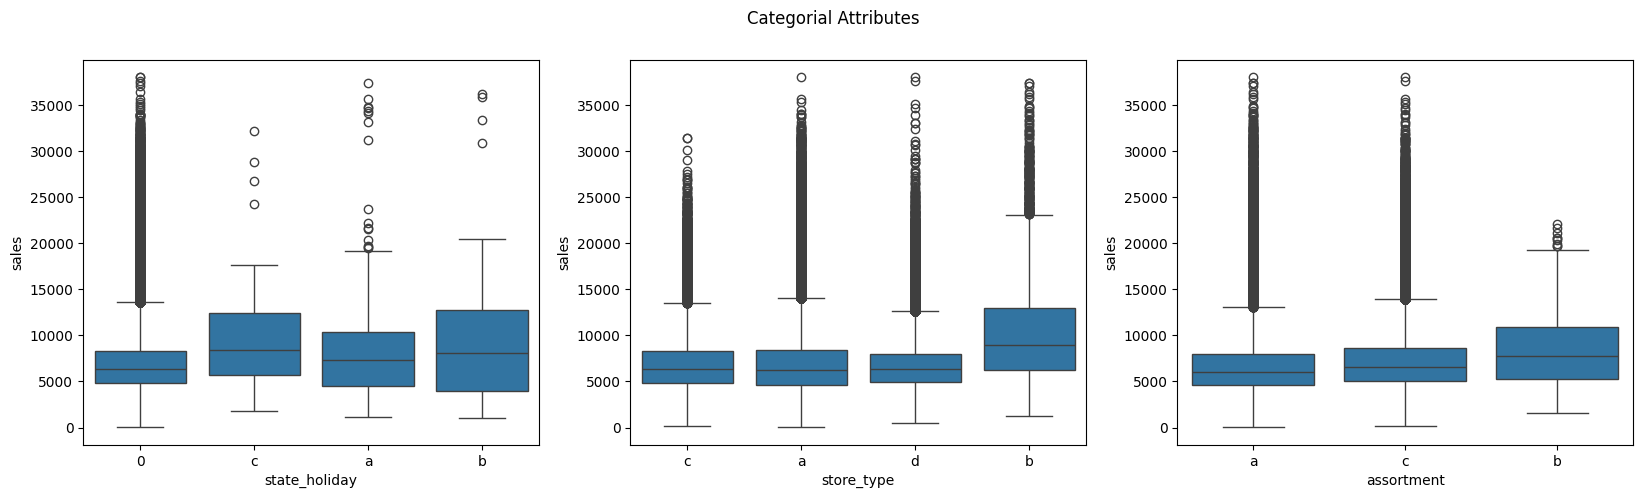

In [16]:
df1_aux = df1[ ( df1['state_holiday'] != 0 )  & ( df1['sales'] > 0 ) ]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Categorial Attributes')

sns.boxplot( ax=axes[0], x='state_holiday', y='sales', data=df1_aux );
sns.boxplot( ax=axes[1], x='store_type',    y='sales', data=df1_aux );
sns.boxplot( ax=axes[2], x='assortment',    y='sales', data=df1_aux );


# 2.0 Feature Engineering

In [17]:
df2 = feature_engineering( df1.copy() )

## 2.1 Hypothesis Mind Map

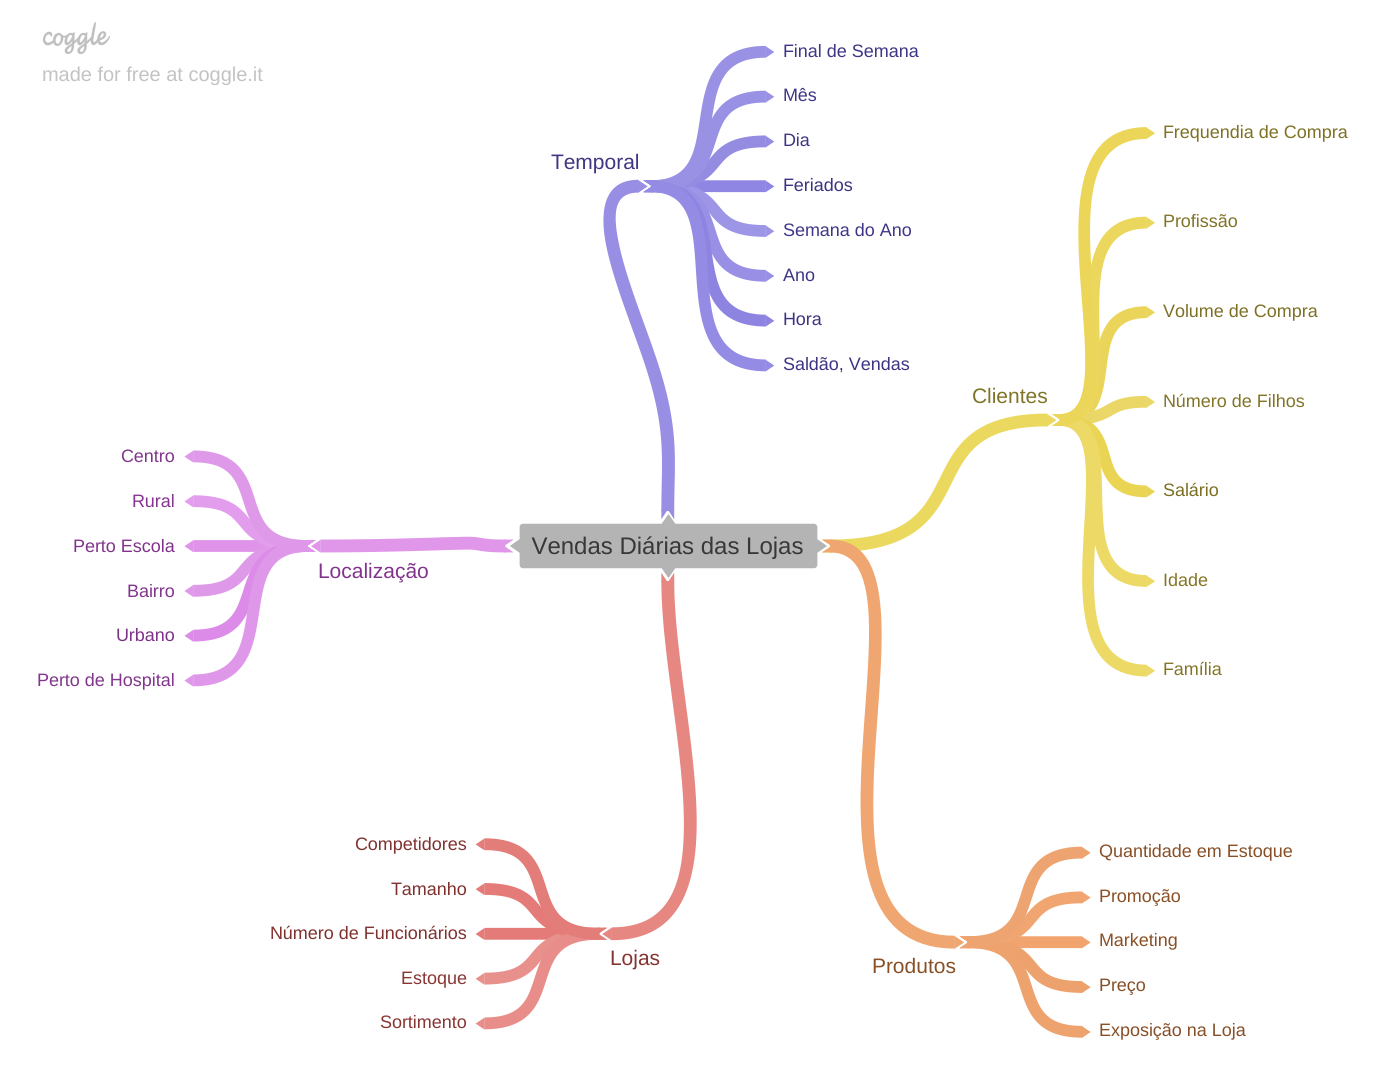

In [18]:
Image( '../img/mapa_de_hipoteses.png')

## 2.2 List of Hypotheses

### 2.2.1 Store Hypothesis

**1.** Lojas com maior número de funcionários deveriam vender mais 

**2.** Lojas com maior estoque deveriam vender mais 

**3.** Lojas de maior porte deveriam vender mais 

**4.** Lojas com maior sortimento deveriam vender mais 

**5.** Lojas com competidores mais próximos deveriam vender menos

**6.** Lojas com competidores a mais tempo deveriam vender mais

### 2.2.2 Product Hypothesis

**1.** Lojas com maior investimento em marketing deveriam vender mais

**2.** Lojas que expõem mais produtos na vitrine deveriam vender mais

**3.** Lojas com produtos com preço menores deveriam vender mais

**4.** Lojas com produtos com preço menores por mais tempo deveriam vender mais

**5.** Lojas com promoções mais agressivas deveriam vender mais

**6.** Lojas com promoções ativas a mais tempo deveriam vender mais

**7.** Lojas com mais dias de promoção deveriam vender mais

**8.** Lojas com mais promoções consecutivas deveriam vender mais

### 2.2.3 Time Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês

**5.** Lojas deveriam vender menos nos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.3 Priority List of Hypotheses

**1.** Lojas com maior sortimento deveriam vender mais (STORE)

**2.** Lojas com competidores mais próximos deveriam vender menos (STORE)

**3.** Lojas com competidores a mais tempo deveriam vender mais (STORE)



**4.** Lojas com promoções ativas a mais tempo deveriam vender mais (PRODUCT)

**5.** Lojas com mais dias de promoção deveriam vender mais (PRODUCT)

**6.** Lojas com mais promoções consecutivas deveriam vender mais (PRODUCT)



**7.** Lojas abertas durante o feriado de Natal deveriam vender mais (TIME)

**8.** Lojas deveriam vender mais ao longo dos anos (TIME)

**9.** Lojas deveriam vender mais no segundo semestre do ano (TIME)

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês (TIME)

**11.** Lojas deveriam vender menos nos finais de semana (TIME)

**12.** Lojas deveriam vender menos durante os feriados escolares (TIME)




## 2.4 Create Features

### 2.4.1 From date column

In [19]:
df2[['date', 'year', 'month', 'day', 'week_of_year', 'year_week']].sample(5)

,date,year,month,day,week_of_year,year_week
493156,2014-04-16,2014,4,16,16,2014-16
416494,2014-06-23,2014,6,23,26,2014-26
866449,2013-05-16,2013,5,16,20,2013-20
856033,2013-05-25,2013,5,25,21,2013-21
296938,2014-10-28,2014,10,28,44,2014-44


### 2.4.2 From competition_open_since columns

In [20]:
df2[['date', 'competition_open_since_year', 'competition_open_since_month', 'competition_since', 'competition_time_month']].sample(5)

,date,competition_open_since_year,competition_open_since_month,competition_since,competition_time_month
572701,2014-02-03,2010,6,2010-06-01,44
281332,2014-11-13,2005,2,2005-02-01,119
404533,2014-07-05,2011,12,2011-12-01,31
872930,2013-05-10,2008,2,2008-02-01,64
337208,2014-09-15,2012,9,2012-09-01,24


### 2.4.3 From promo2_since columns

In [21]:
df2[['promo2_since_year', 'promo2_since_week', 'promo2_since', 'date', 'promo2_time_week']].sample(5)

,promo2_since_year,promo2_since_week,promo2_since,date,promo2_time_week
468694,2012,1,2011-12-26,2014-05-07,123
788521,2013,30,2013-07-22,2013-07-25,0
243312,2013,40,2013-09-30,2014-12-24,64
721156,2012,1,2011-12-26,2013-09-23,91
314282,2014,41,2014-10-06,2014-10-09,0


### 2.4.4 From assorment column

In [22]:
df2['assortment'].value_counts()

assortment
basic       340937
extended    301071
extra         6301
Name: count, dtype: int64

### 2.4.5 From state_holiday column

In [23]:
df2['state_holiday'].value_counts()

state_holiday
regular day       647641
public holiday       501
easter holiday        96
christmas             71
Name: count, dtype: int64

## 2.5 Filtering Variables

### 2.5.1 Filtering Lines

In [24]:
df2.sample(5)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week
414354,360,3,2014-06-25,4347,0,regular day,0,a,basic,2040.0,...,0,2014,6,25,26,2014-26,2007-06-01,86,2014-06-23,0
468261,747,4,2014-05-08,9312,1,regular day,0,c,extended,45740.0,...,0,2014,5,8,19,2014-19,2008-08-01,70,2014-05-05,0
694372,513,4,2013-10-17,15867,0,regular day,0,a,basic,400.0,...,0,2013,10,17,42,2013-42,2013-08-01,2,2013-10-14,0
468477,963,4,2014-05-08,13614,1,regular day,0,a,extended,23620.0,...,0,2014,5,8,19,2014-19,2013-11-01,6,2014-05-05,0
871868,724,6,2013-05-11,5509,0,regular day,0,d,extended,5900.0,...,0,2013,5,11,19,2013-19,2013-05-01,0,2013-05-06,0


### 2.5.2 Filtering Columns

In [25]:
df2.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo2_since', 'promo2_time_week'],
      dtype='object')

# 3.0 Exploratory Data Analysis

In [26]:
df3 = df2.copy()

## 3.1 Univariate Analysis

### 3.1.1 Response Variable

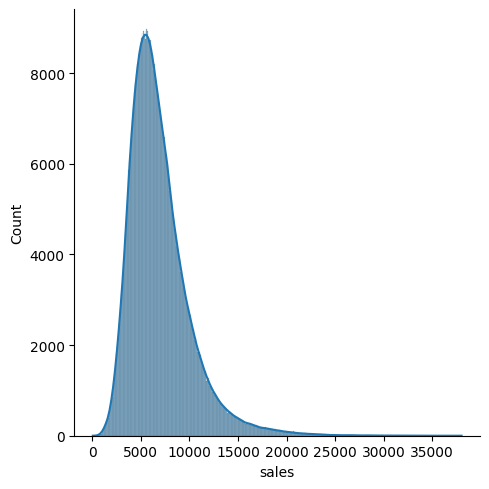

In [27]:
# checking distribuition 
sns.displot( df3['sales'], kde='hist');

### 3.1.2 Numerical Variables

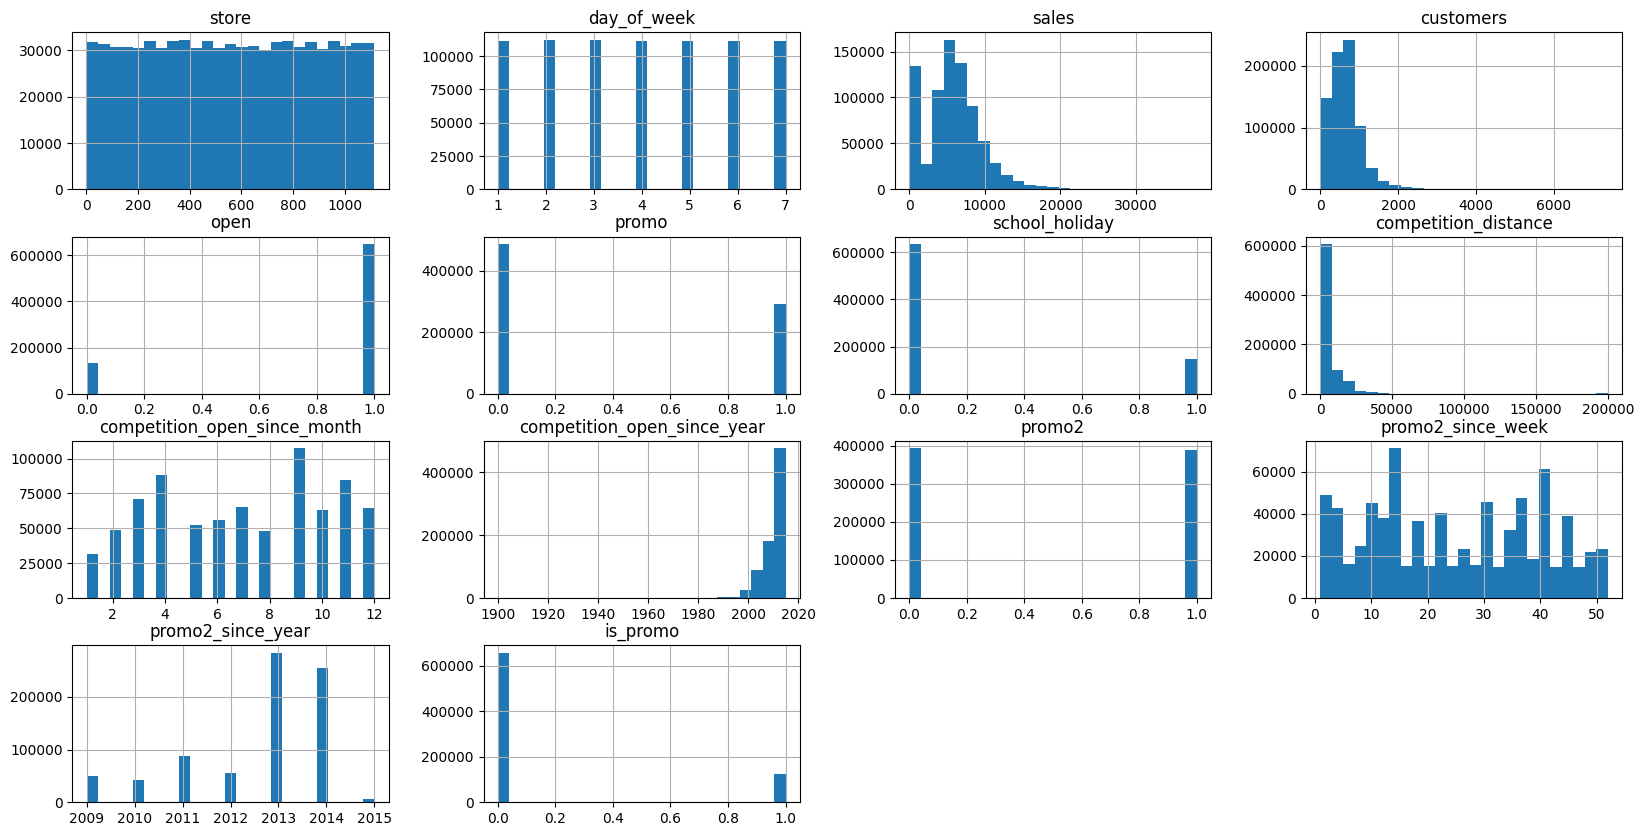

In [28]:
# cheking distribuition
df_num_attributes.hist( bins=25, figsize=(20, 10) );

##### Notas do gráfico: 

**1.** A variável "competition_open_since_month" apresenta vários comportamentos, e quantos mais comportamentos uma variável possui melhor para o aprendizado do modelo.

**2.** Já a variável "day_of_week" apresenta um comportamente constante, não há variação, esse tipo de variável sozinha não serve para o aprendizado modelo

### 3.1.3 Categorical Variables

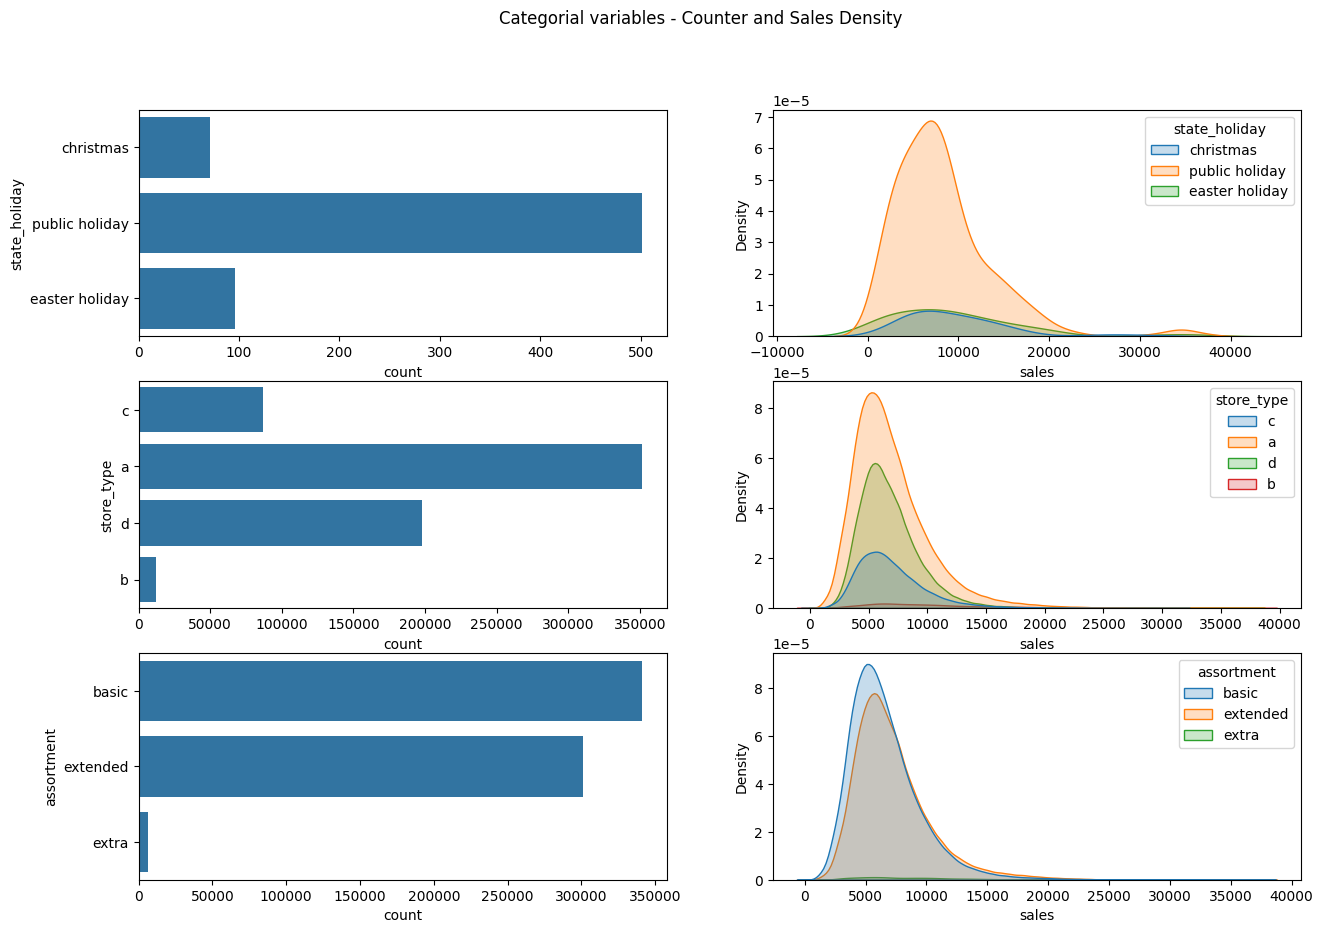

In [29]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('Categorial variables - Counter and Sales Density')

# state_holiday
sns.countplot( ax=axes[0,0], data=df3[ df3['state_holiday'] !=  'regular day' ]['state_holiday'] );
sns.kdeplot  ( ax=axes[0,1], data=df3[ df3['state_holiday'] !=  'regular day' ][['state_holiday', 'sales']], x='sales',  hue='state_holiday', fill=True );

# store_type
sns.countplot( ax=axes[1,0], data=df3['store_type'] );
sns.kdeplot  ( ax=axes[1,1], data=df3[['store_type', 'sales']], x='sales',  hue='store_type', fill=True );

# assortment
sns.countplot( ax=axes[2,0], data=df3['assortment'] );
sns.kdeplot  ( ax=axes[2,1], data=df3[['assortment', 'sales']], x='sales',  hue='assortment', fill=True );


## 3.2 Bivariate Analysis

### H1 - Lojas com maior sortimento deveriam vender mais (STORE)

***FALSA*** Lojas com MAIOR SORTIMENTO vendem MENOS

***ASSORTMENT*** Apresenta comportamento variável na classe "extra", mas com um volume pequeno de dados, portanto, relevância BAIXA para o modelo

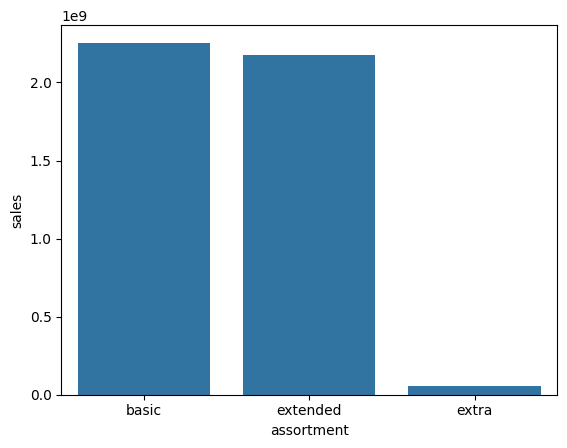

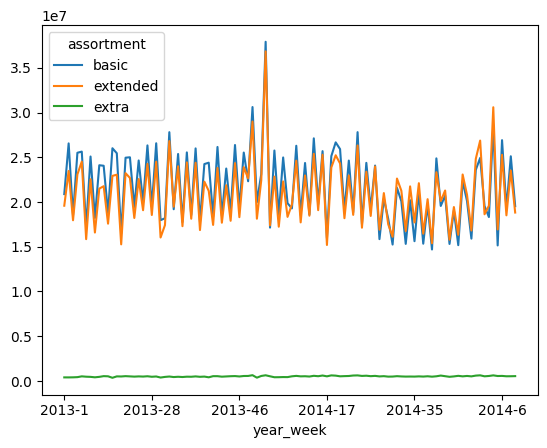

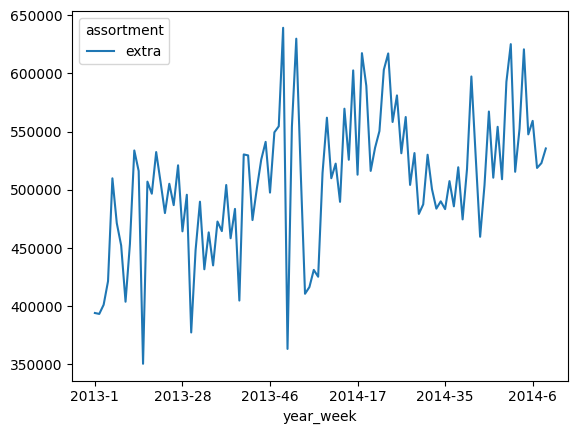

In [30]:
# sales x assortments - total
aux = df3[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux );

# sales x assortments - timeline 
aux2 = df3[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();

# sales x assortments - only "extra" assortment
aux3 = aux2[ aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();


### H2 - Lojas com competidores mais próximos deveriam vender menos (STORE)

**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS

**COMPETITION_DISTANCE** apresenta uma correlação FRACA com a variável resposta

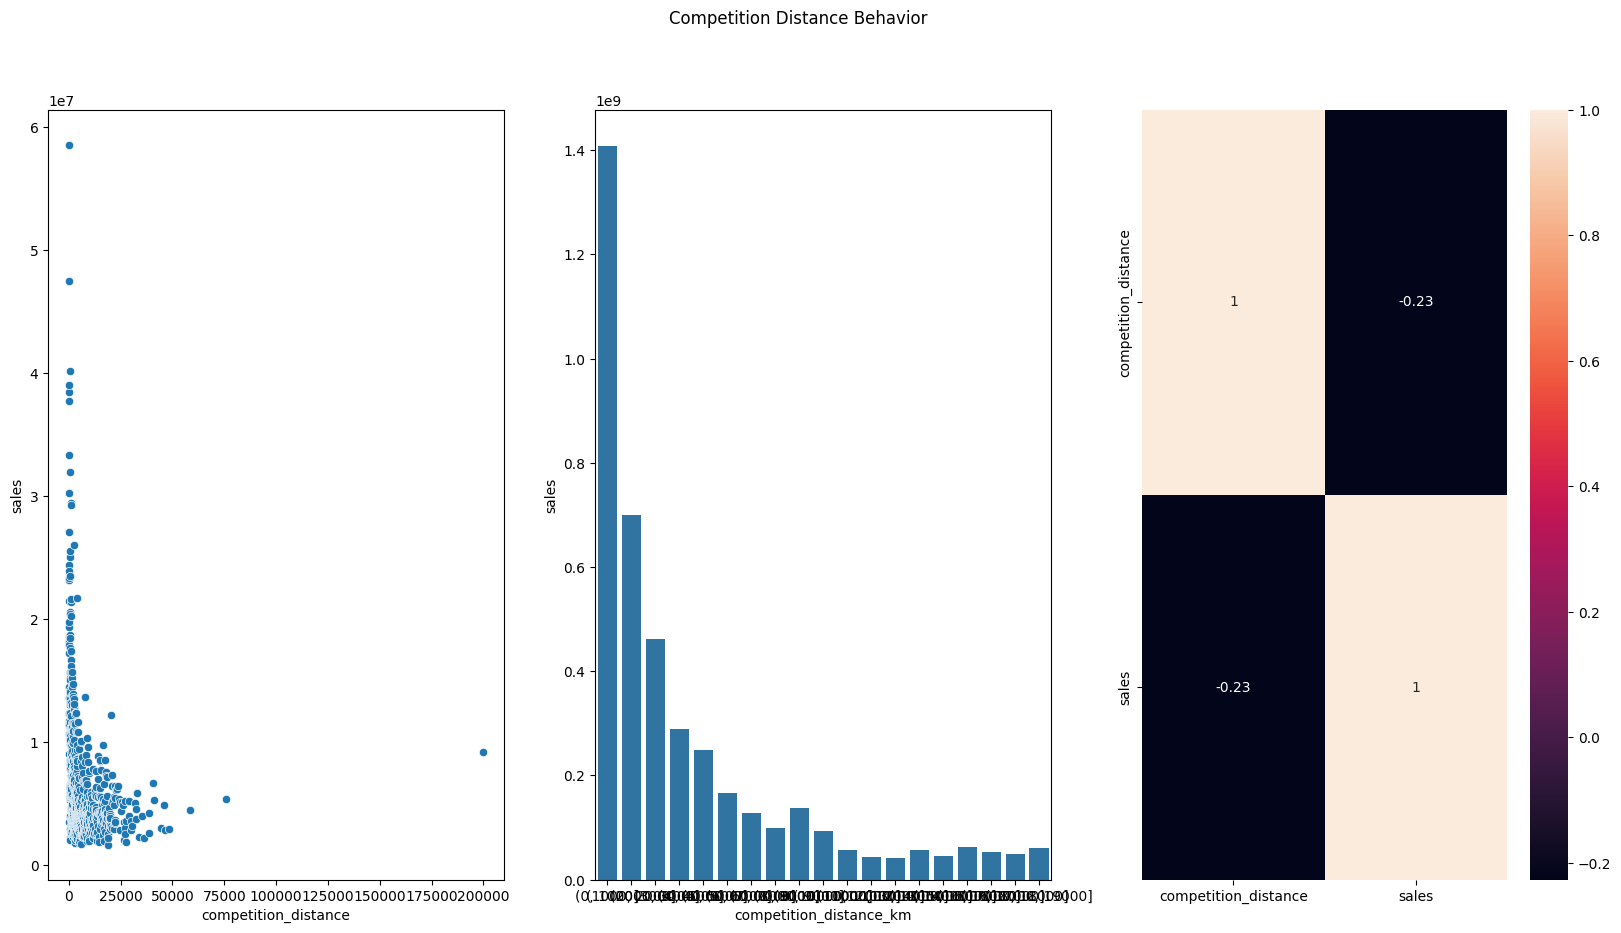

In [31]:

fig, axes = plt.subplots(1, 3, figsize=(20, 10) )
fig.suptitle('Competition Distance Behavior')


# sales x competition_distance - total
aux1 = df3[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
sns.scatterplot( ax=axes[0], x='competition_distance', y='sales', data=aux1 );


# sales x competition_distance - grouped by km
competition_distance_km = list( np.arange(0, 20000, 1000) )
aux1['competition_distance_km'] = pd.cut( aux1['competition_distance'], bins=competition_distance_km )
aux2 = aux1[['competition_distance_km', 'sales']].groupby( 'competition_distance_km' ).sum().reset_index()
sns.barplot( ax=axes[1], x='competition_distance_km', y='sales', data=aux2 );


# sales x competition_distance corr method
aux3 = aux1[['competition_distance', 'sales']]
sns.heatmap( aux3.corr( method='pearson' ), annot=True, ax=axes[2] );


### H3 - Lojas com competidores a mais tempo deveriam vender mais (STORE)



**FALSA** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS

**COMPETITION_TIME_MONTH** possui um correlação com a variável resposta muito próxima de ZERO, portanto, BAIXA CORRELAÇÃO

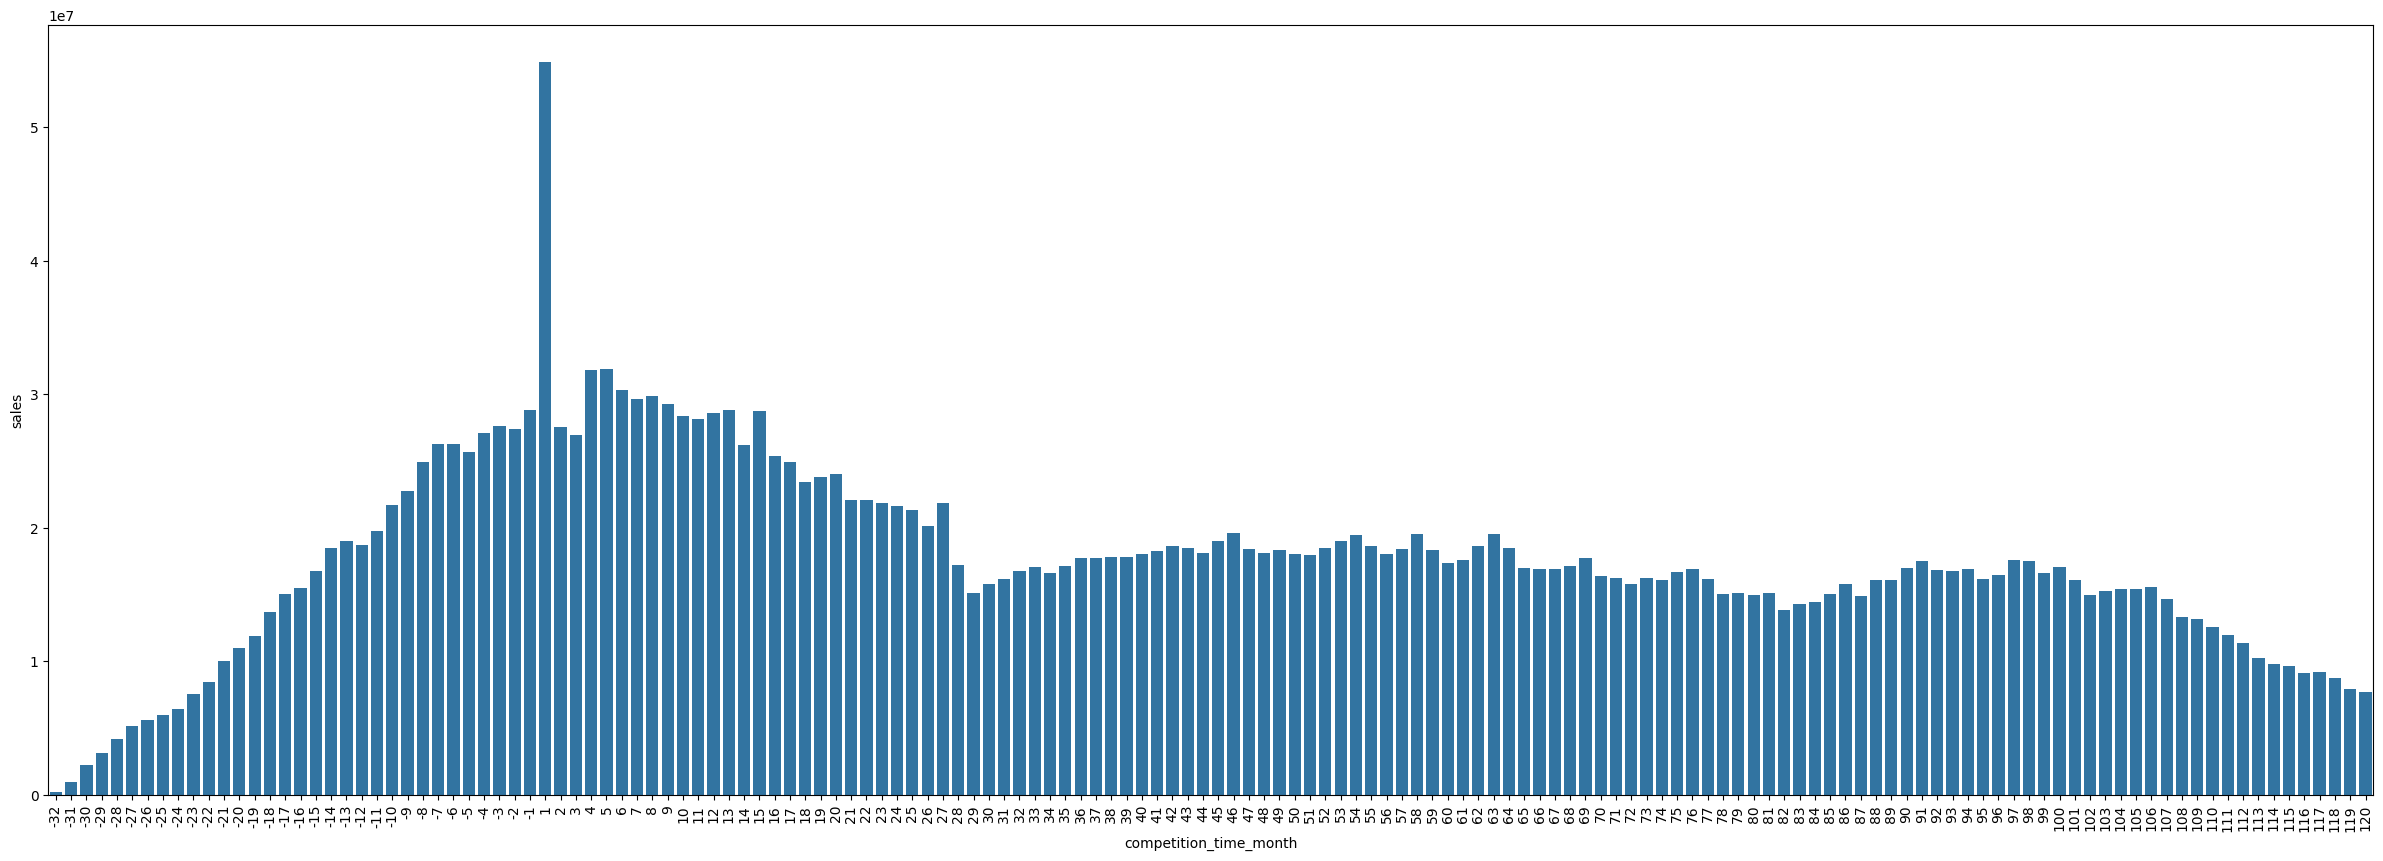

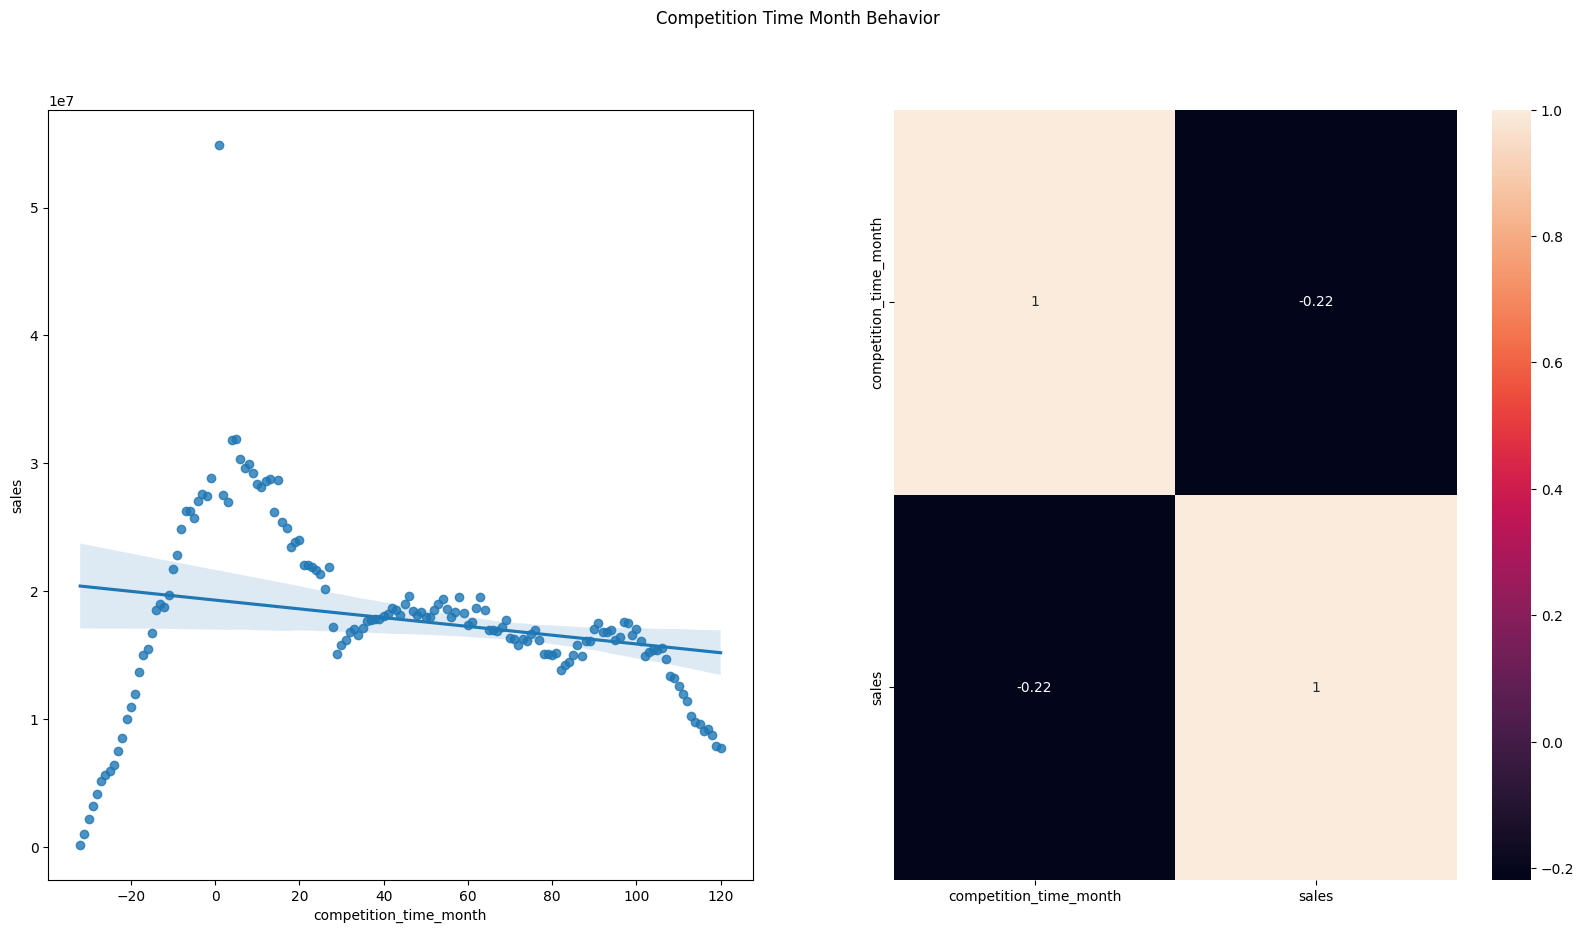

In [32]:
aux1 = df3[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux1 = aux1[ ( aux1['competition_time_month'] != 0 ) & ( aux1['competition_time_month'] <= 120 ) ]

plt.figure(figsize=(30,10));
plt.xticks( rotation='vertical');
sns.barplot( x='competition_time_month', y='sales', data=aux1 );

fig, axes = plt.subplots(1, 2, figsize=(20, 10) )
fig.suptitle('Competition Time Month Behavior')

# sales x competition_time_month 
sns.regplot( x='competition_time_month', y='sales', data=aux1, ax=axes[0] );

# sales x competition_distance corr method
sns.heatmap( aux1.corr( method='pearson' ), annot=True, ax=axes[1] );


### H4 - Lojas com promoções ativas a mais tempo deveriam vender mais (PRODUCT)





**FALSA** Lojas com PROMOÇÔES ATIVAS A MAIS TEMPO vendem MENOS depois de um certo período de promoção

**PROMO2_TIME_WEEK** possui uma correlação FRACA com a variável resposta

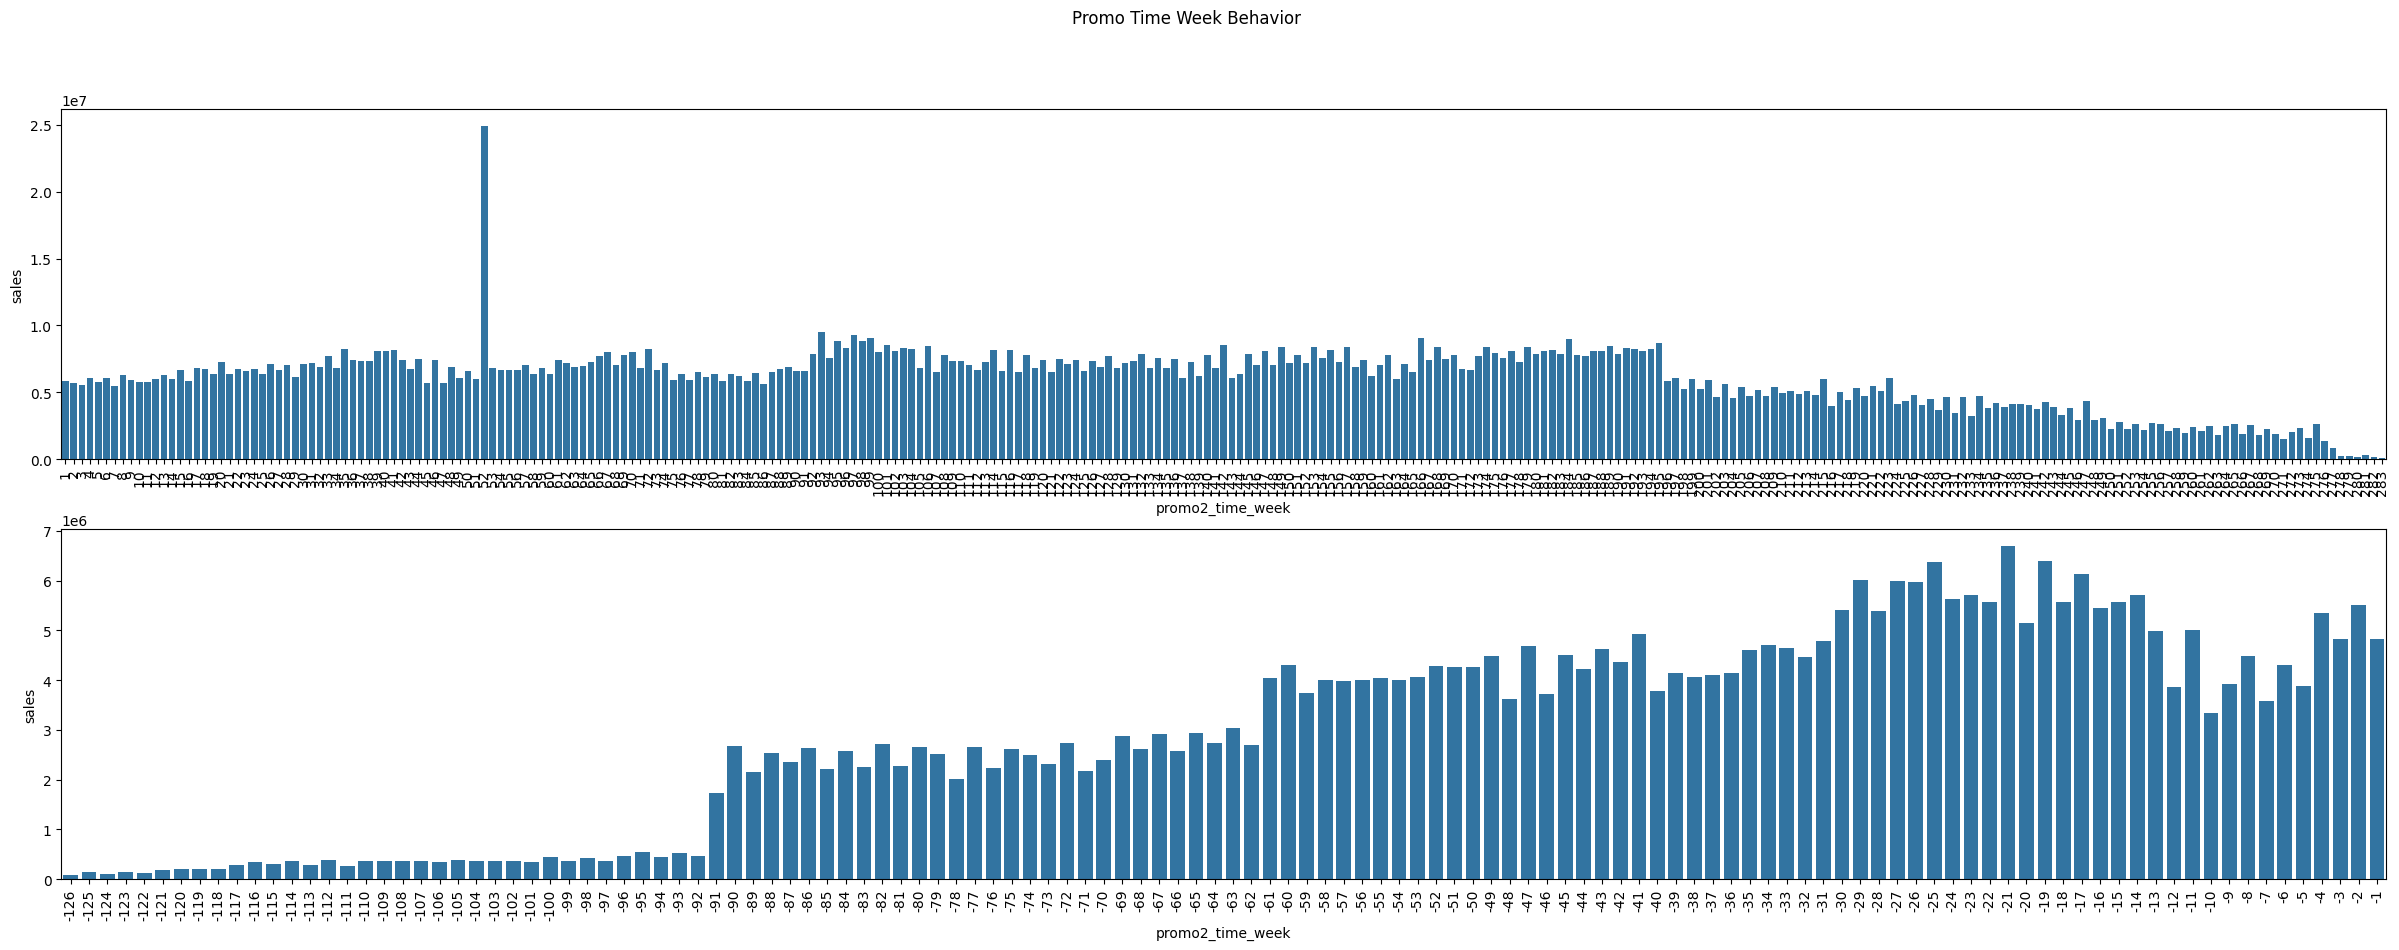

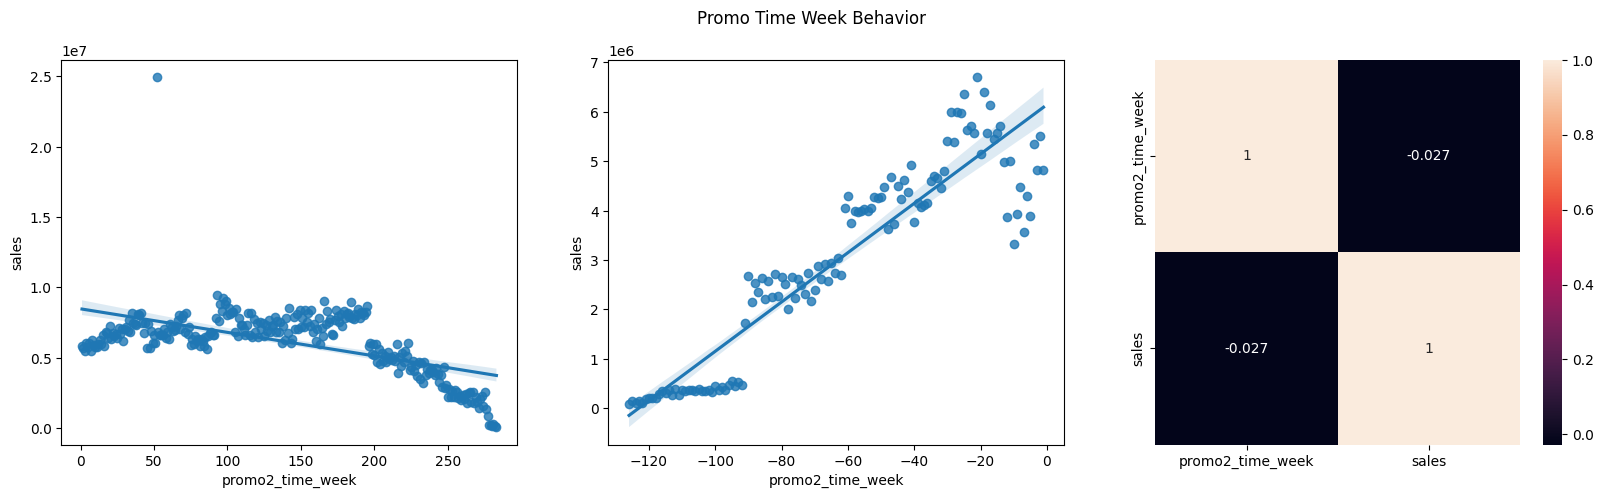

In [33]:
aux1 = df3[['promo2_time_week', 'sales']].groupby( 'promo2_time_week').sum().reset_index()
#sns.barplot( x='promo2_time_week', y='sales', data=aux1 );

# extended promo
aux2 = aux1[ aux1['promo2_time_week'] > 0 ] 

# regular promo
aux3 = aux1[ aux1['promo2_time_week'] < 0 ] 

fig, axes = plt.subplots(2, 1, figsize=(30, 10),  )
fig.suptitle('Promo Time Week Behavior')

axes[0].xaxis.set_tick_params( rotation=90 )
axes[1].xaxis.set_tick_params( rotation=90 )


sns.barplot( x='promo2_time_week', y='sales', data=aux2, ax=axes[0] );
sns.barplot( x='promo2_time_week', y='sales', data=aux3, ax=axes[1] );

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Promo Time Week Behavior')

sns.regplot( x='promo2_time_week', y='sales', data=aux2, ax=axes[0] );
sns.regplot( x='promo2_time_week', y='sales', data=aux3, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );


### <s> H5 - Lojas com mais dias de promoção deveriam vender mais (PRODUCT) </s>

**ON HOLD** Será necessária a criação de uma variável com a quantidade de dias em promoção. Fica para a próxima rodada do CRISP-DS

### H6 - Lojas com mais promoções consecutivas deveriam vender mais (PRODUCT)

**FALSA** Lojas com MAIS PROMOÇÔES CONSECUTIVAS vendem MENOS

**PROMO E PROMO2** aprensentam o mesmo comportamente em relação as vendas, portanto, ambas apresentam um correlação FRACA com a variável resposta

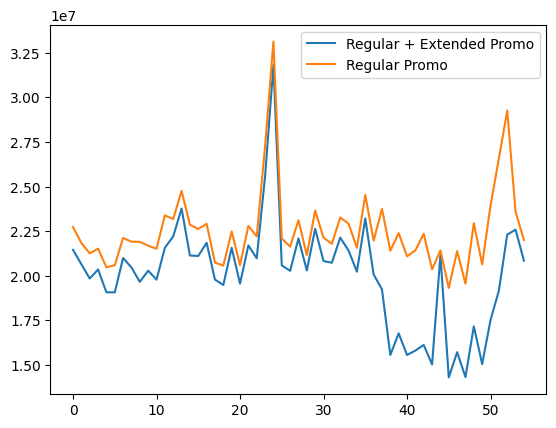

In [34]:
# regular and extended promo
aux1 = df3[ ( df3['promo'] == 1 ) & ( df3['promo2'] == 1 ) ][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

# regular promo
aux2 = df3[ ( df3['promo'] == 1 ) & ( df3['promo2'] == 0 ) ][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Regular + Extended Promo', 'Regular Promo'] );

### H7 -  Lojas abertas durante o feriado de Natal deveriam vender mais (TIME)

**FALSA**, Lojas abertas durante o feriado de Natal vendem MENOS

**STATE_HOLIDAY** possui comportamentos distintos entre os tipos de feriados e por isso ter uma correlação FORTE com a variável resposta

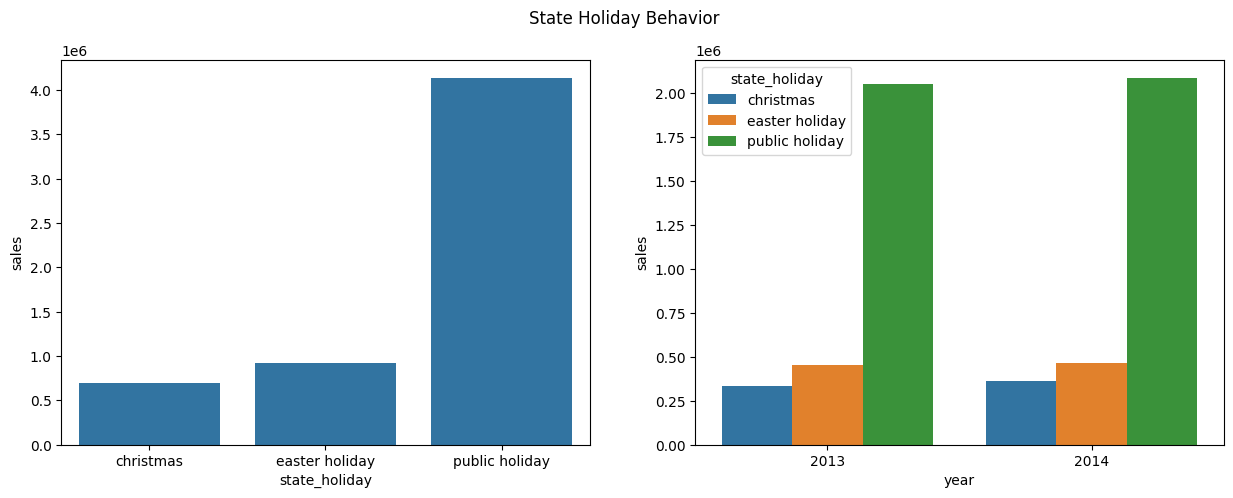

In [35]:
aux1 = df3[ df3['state_holiday'] != 'regular day'][['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
aux2 = df3[ df3['state_holiday'] != 'regular day'][['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(15, 5) )
fig.suptitle('State Holiday Behavior')

sns.barplot( x='state_holiday', y='sales', data=aux1, ax=axes[0] );
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2, ax=axes[1] );



### H8 - Lojas deveriam vender mais ao longo dos anos (TIME)

**FALSA** Lojas vendem MENOS ao longo dos anos

**YEAR** Possui uma correlação FORTE com a variável resposta

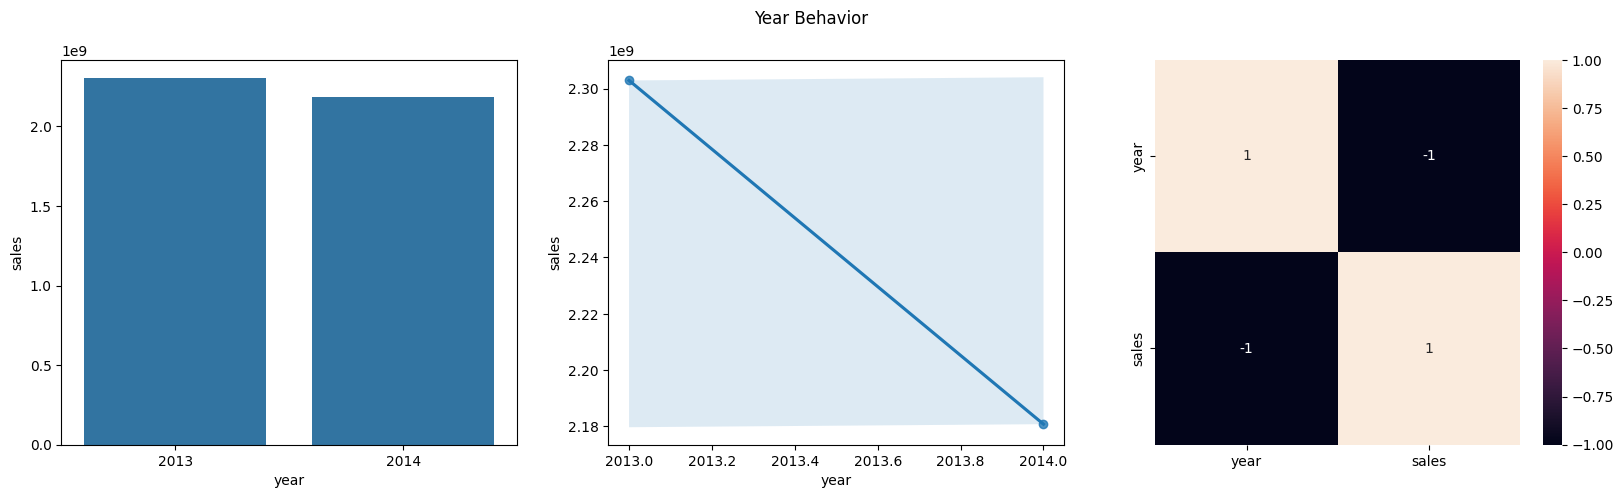

In [36]:
aux1 = df3[['year', 'sales']].groupby( 'year' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Year Behavior')

sns.barplot( x='year', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='year', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );


### H9 - Lojas deveriam vender mais no segundo semestre do ano (TIME)

**FALSA** Lojas vendem MENOS no segundo semestre do ANO

**MONTH** possui uma ALTA correlação com a variável resposta

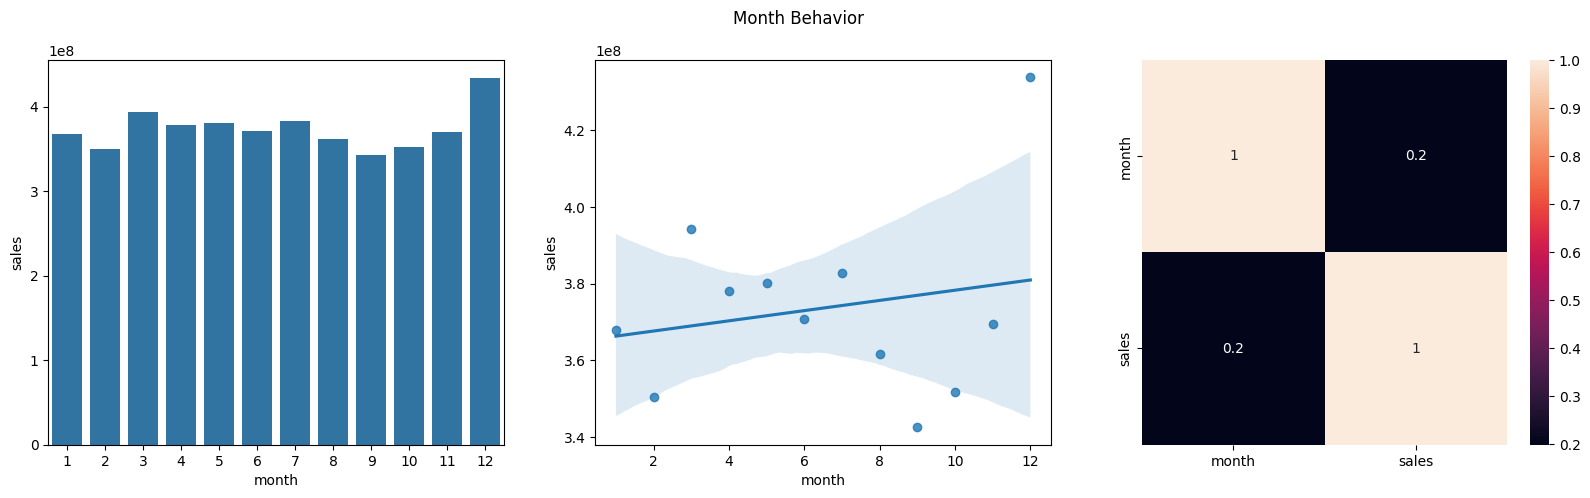

In [37]:
aux1 = df3[['month', 'sales']].groupby( 'month' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Month Behavior')

sns.barplot( x='month', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='month', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );

### H10 - Lojas deveriam vender mais depois do dia 10 de cada mês (TIME)

**VERDADEIRA** Lojas vendem MAIS depois do dia 10 de cada mês

**DAY** possui uma correlação MÉDIA com a variável resposta

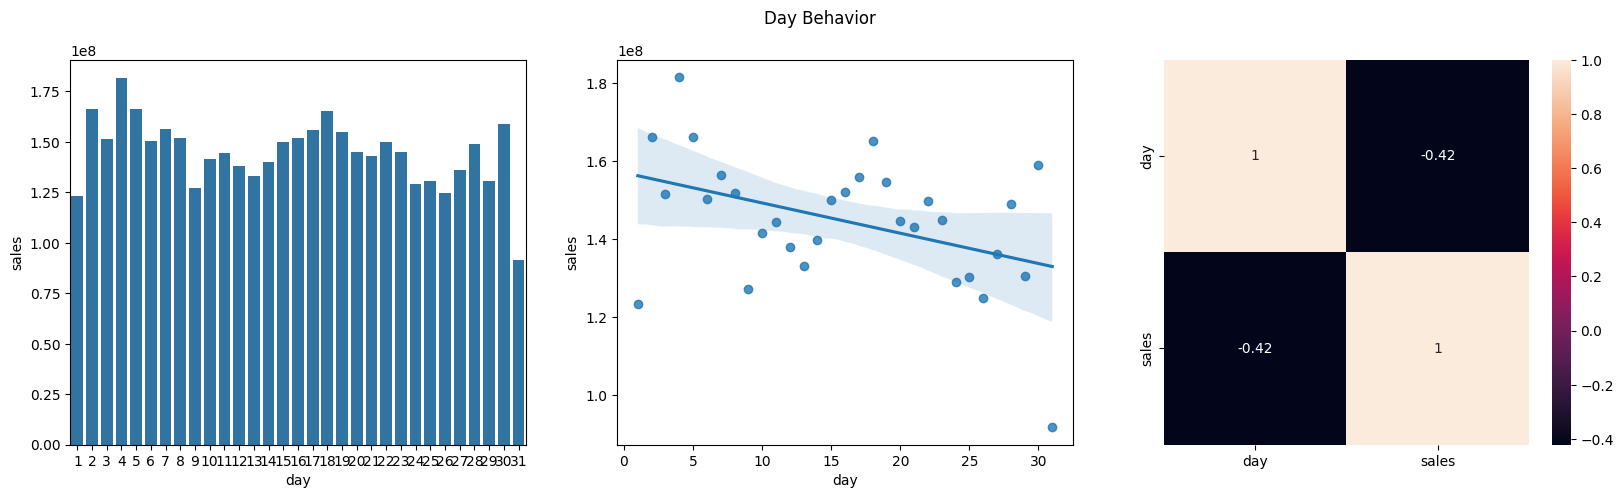

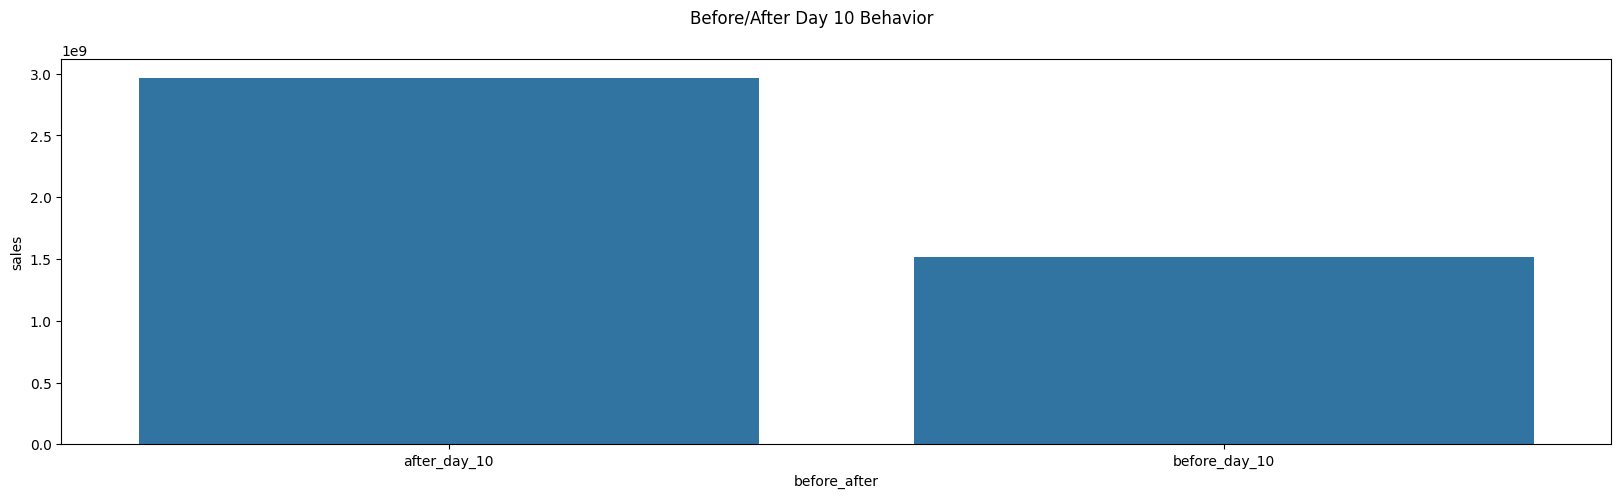

In [38]:
aux1 = df3[['day', 'sales']].groupby( 'day' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Day Behavior')

sns.barplot( x='day', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='day', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_day_10' if x <= 10 else 'after_day_10')
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

fig, axes = plt.subplots(1, 1, figsize=(20, 5) )
fig.suptitle('Before/After Day 10 Behavior')

sns.barplot( x='before_after', y='sales', data=aux2 );

### H11 -  Lojas deveriam vender menos nos finais de semana (TIME)

**VERDADEIRA** Lojas vendem MENOS nos finais de semana

**DAY_OF_WEEK** possui uma correlação ALTA com a variável resposta

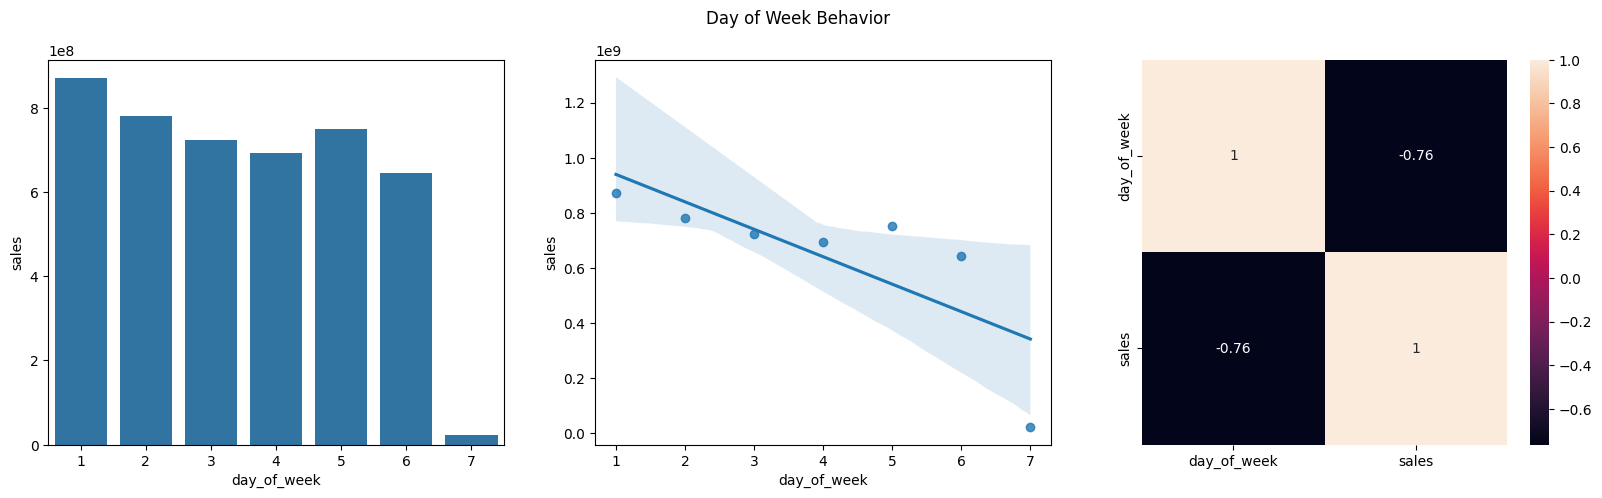

In [39]:
aux1 = df3[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('Day of Week Behavior')

sns.barplot( x='day_of_week', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='day_of_week', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );

### H12 - Lojas deveriam vender menos durante os feriados escolares (TIME)

**VERDADEIRA** Lojas vendem MENOS durante  os feriados escolares, exceto mês de agosto

**SCHOOL_HOLIDAY** possui uma correlação ALTA com a variável resposta, no entanto, possui pouca variação de comportamento

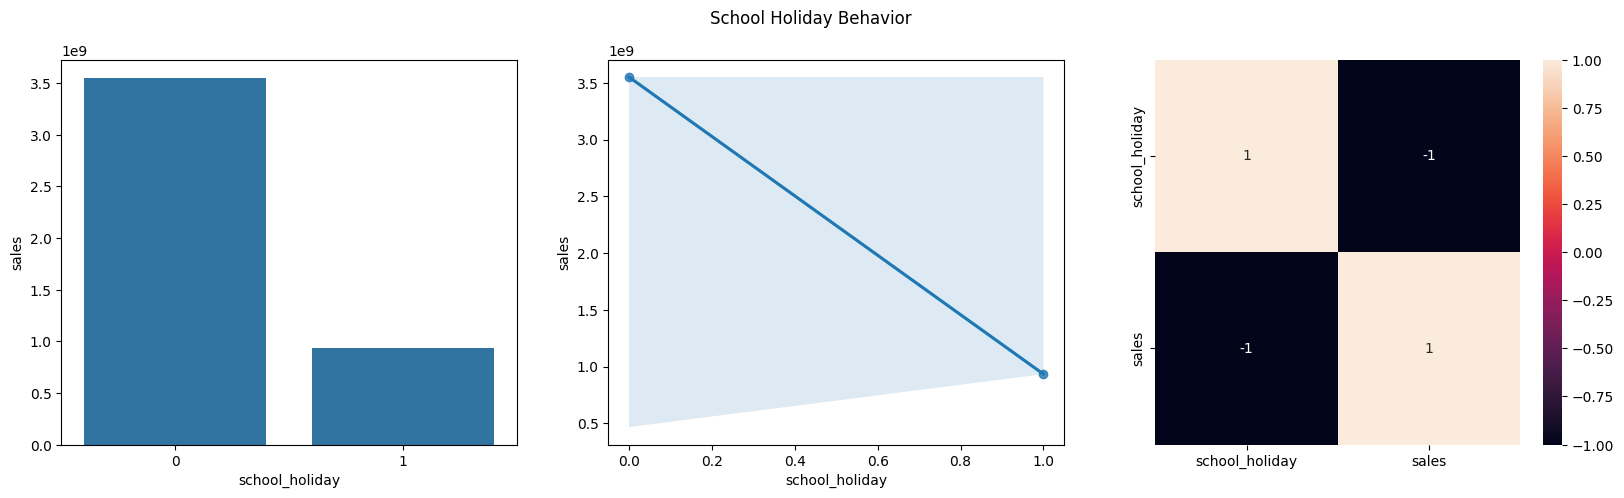

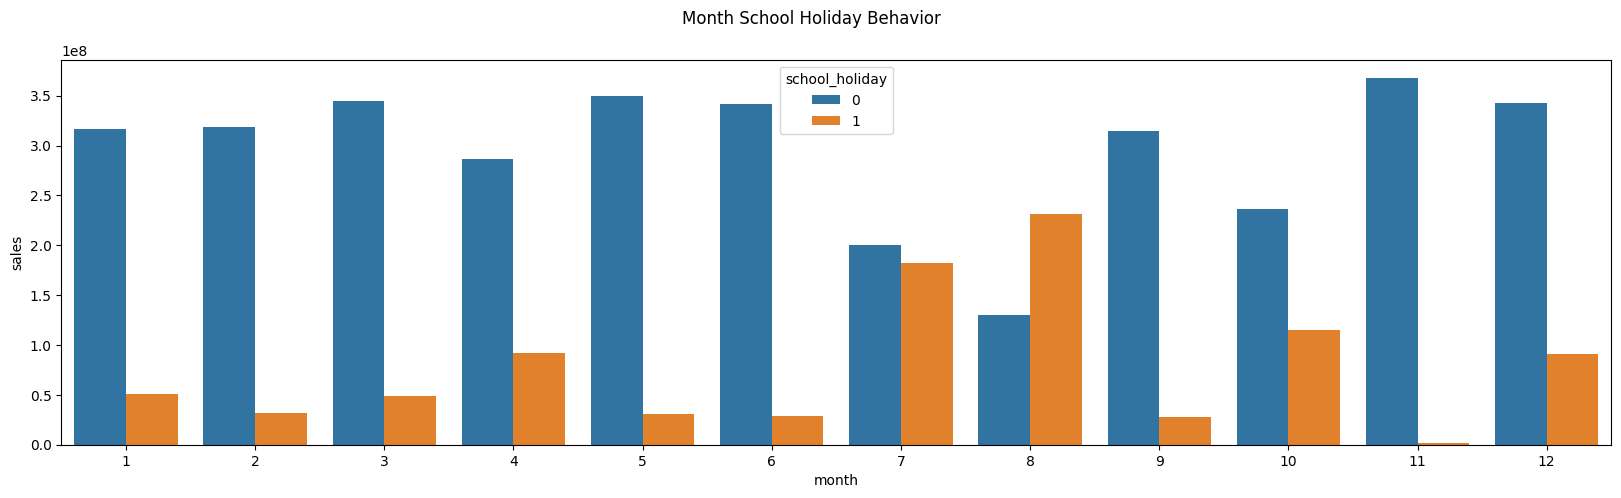

In [40]:
aux1 = df3[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5) )
fig.suptitle('School Holiday Behavior')

sns.barplot( x='school_holiday', y='sales', data=aux1, ax=axes[0] );
sns.regplot( x='school_holiday', y='sales', data=aux1, ax=axes[1] );
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2] );


aux2 = df3[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()

fig, axes = plt.subplots(1, 1, figsize=(20, 5) )
fig.suptitle('Month School Holiday Behavior')

sns.barplot( x='month', hue='school_holiday', y='sales', data=aux2 );

### 3.2.1 Resumo das Hipóteses

In [41]:
tab = [ ['Hipóteses', 'Conclusão', 'Relevância'],
        ['H1', 'Falsa', 'Baixa'],
        ['H2', 'Falsa', 'Baixa'],
        ['H3', 'Falsa', 'Baixa'],
        ['H4', 'Falsa', 'Baixa'],
        ['H5', '-', '-'],
        ['H6', 'Falsa', 'Baixa'],
        ['H7', 'Falsa', 'Alta'],
        ['H8', 'Falsa', 'Alta'],
        ['H9', 'Falsa', 'Alta'],
        ['H10', 'Verdadeira', 'Média'],
        ['H11', 'Verdadeira', 'Alta'],
        ['H12', 'Verdadeira', 'Baixa'],
]

print( tabulate( tab, headers='firstrow' ) )

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Baixa
H3           Falsa        Baixa
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Alta
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Média
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 3.3 Multivariate Analysis

### 3.3.1 Numerical Attributes

<Axes: >

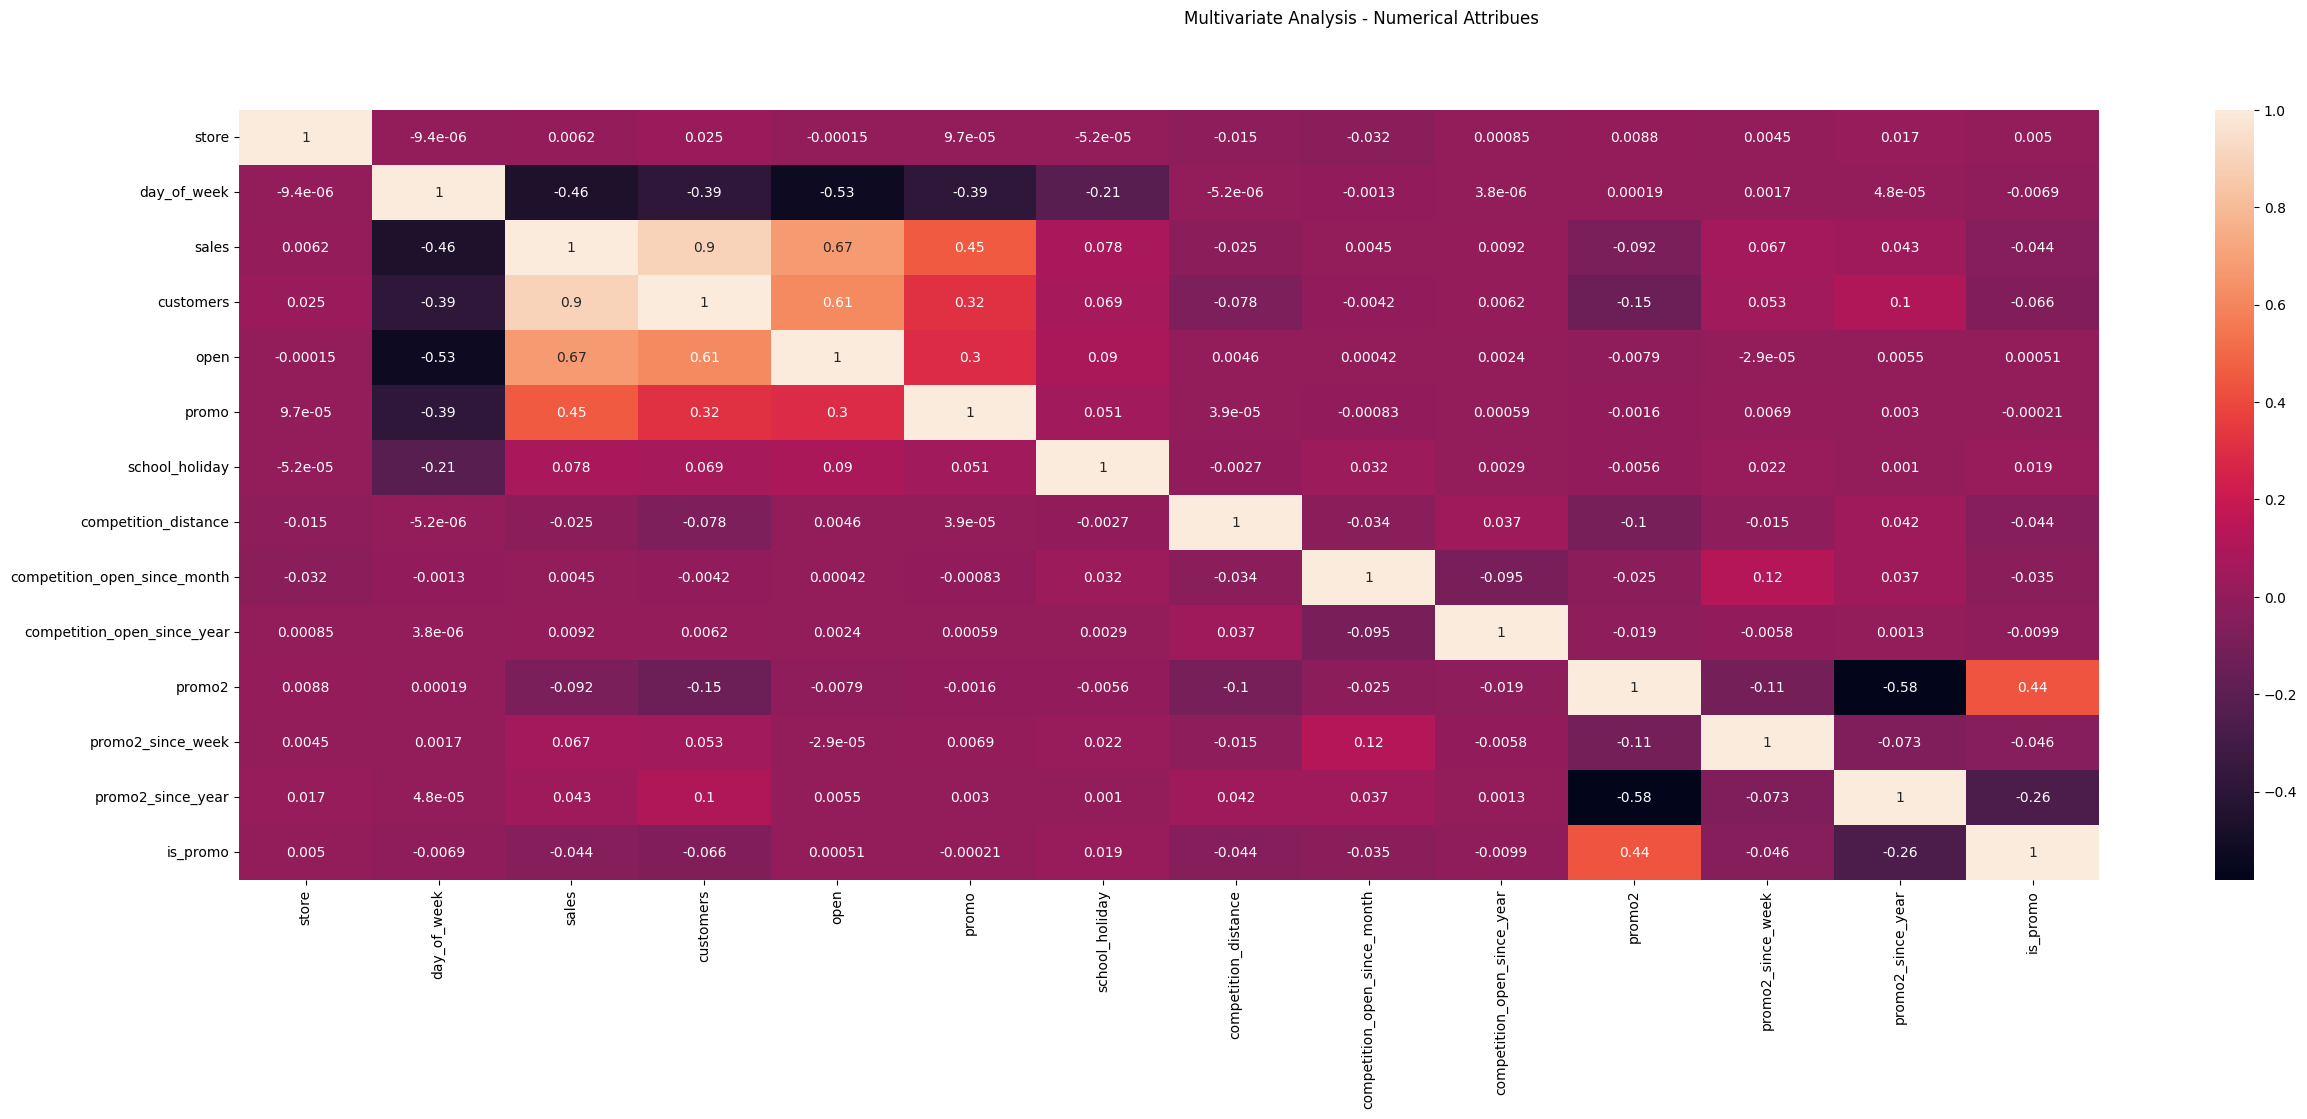

In [42]:
correlation = df_num_attributes.corr( method='pearson' )

fig, axes = plt.subplots(1, 1, figsize=(30, 10) )
fig.suptitle('Multivariate Analysis - Numerical Attribues ')

sns.heatmap( correlation, annot=True )

### 3.3.2 Categorical Attributes

In [43]:
# create a dataframe with new categorical columns
cat = df3.select_dtypes( include='object' )
cat.sample(5)


,state_holiday,store_type,assortment,year_week
493102,regular day,a,extended,2014-16
583170,regular day,a,basic,2014-4
653139,regular day,a,basic,2013-47
462065,regular day,d,basic,2014-20
294816,regular day,a,basic,2014-44


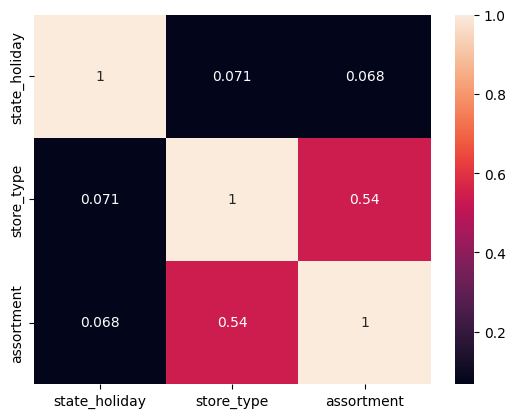

In [44]:
# calculate cramer´s v for all columns combinations 
cv1 = cramer_v( cat['state_holiday'], cat['state_holiday'] )
cv2 = cramer_v( cat['state_holiday'], cat['store_type'] )
cv3 = cramer_v( cat['state_holiday'], cat['assortment'] )

cv4 = cramer_v( cat['store_type'], cat['state_holiday'] )
cv5 = cramer_v( cat['store_type'], cat['store_type'] )
cv6 = cramer_v( cat['store_type'], cat['assortment'] )

cv7 = cramer_v( cat['assortment'], cat['state_holiday'] )
cv8 = cramer_v( cat['assortment'], cat['store_type'] )
cv9 = cramer_v( cat['assortment'], cat['assortment'] )

# create final dataframe
df = pd.DataFrame( { 'state_holiday' : [cv1, cv2, cv3],
                     'store_type'    : [cv4, cv5, cv6],
                     'assortment'    : [cv7, cv8, cv9],
                    })
df = df.set_index( df.columns )

# plot correlations between categorical attributes
sns.heatmap( df, annot=True);

# 4.0 Data Preparation

In [45]:
df4 = data_preparation( df3.copy(), 'train' )

## 4.1 Normalization Method

**COMENTÁRIO:** Ao observar a distribuição das variáveis numéricas (seção 3.1.2), nota-se que NÃO HÁ variáveis com distribuição NORMAL, portanto, não há sentido em executar o método de normalização nesse conjunto de dados

## 4.2 Rescaling Method

### 4.2.1 Min-Max Scaler

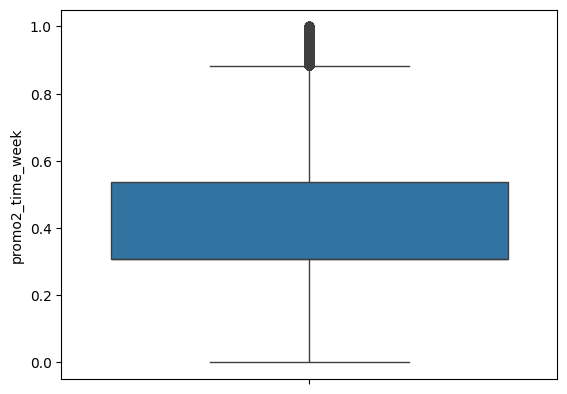

In [46]:
# promo2_time_wee - Few outliers 
sns.boxplot( df4['promo2_time_week'] );

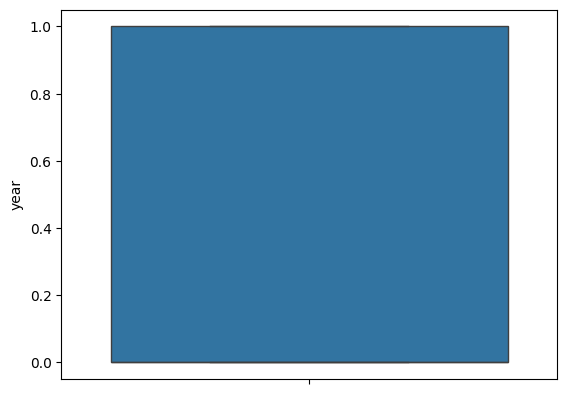

In [47]:

# year - Few outliers 
sns.boxplot( df4['year'] );

### 4.2.2 Robuster Scaler

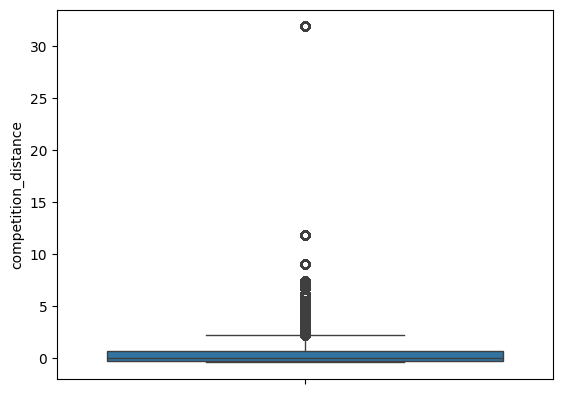

In [48]:
# competition_distance - Many outliers 
sns.boxplot( df4['competition_distance'] );

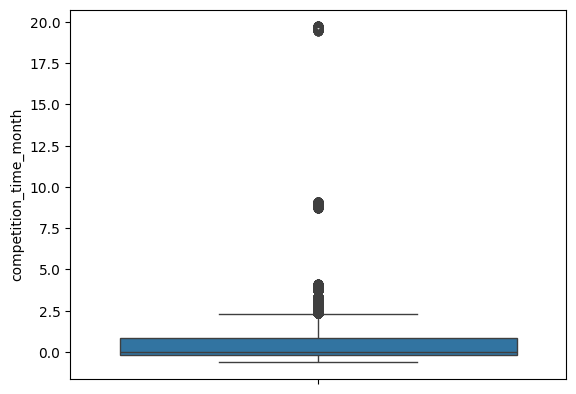

In [49]:
# competition_time_month - Many outliers 
sns.boxplot( df4['competition_time_month'] );

## 4.3 Transformation Method

### 4.3.1 Encoding Transformation

#### state_holiday column

In [50]:
df4.sample(5)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public holiday,state_holiday_regular day,month_sin,month_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
735568,454,2,2013-09-10,8.907883,1,0,0,1,3.890323,9,...,False,True,-1.000000e+00,-1.836970e-16,0.974928,-0.222521,0.866025,-0.500000,-0.970942,-0.239316
378427,1030,6,2014-08-02,7.497207,0,0,0,1,5.496774,4,...,False,True,-8.660254e-01,-5.000000e-01,-0.781831,0.623490,0.406737,0.913545,-0.568065,-0.822984
533678,379,1,2014-03-10,8.049108,0,0,3,1,0.693548,3,...,False,True,1.000000e+00,6.123234e-17,0.781831,0.623490,0.866025,-0.500000,0.970942,0.239316
827899,240,3,2013-06-19,8.644178,1,1,0,1,-0.196774,5,...,False,True,1.224647e-16,-1.000000e+00,0.433884,-0.900969,-0.743145,-0.669131,0.120537,-0.992709
727811,502,2,2013-09-17,9.197559,0,0,0,1,-0.340323,2,...,False,True,-1.000000e+00,-1.836970e-16,0.974928,-0.222521,-0.406737,-0.913545,-0.992709,-0.120537


#### store_type column

In [51]:
df4.sample(5)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public holiday,state_holiday_regular day,month_sin,month_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
953144,605,3,2013-02-27,8.352319,0,0,3,1,1.287097,4,...,False,True,8.660254e-01,0.500000,0.433884,-0.900969,-0.587785,0.809017,8.854560e-01,0.464723
988718,499,6,2013-01-26,8.419580,0,0,2,3,-0.303226,1,...,False,True,5.000000e-01,0.866025,-0.781831,0.623490,-0.743145,0.669131,4.647232e-01,0.885456
869947,1033,1,2013-05-13,9.880270,1,0,0,1,0.862903,3,...,False,True,5.000000e-01,-0.866025,0.781831,0.623490,0.406737,-0.913545,6.631227e-01,-0.748511
448356,912,1,2014-05-26,8.489411,0,0,2,3,0.124194,5,...,False,True,5.000000e-01,-0.866025,0.781831,0.623490,-0.743145,0.669131,4.647232e-01,-0.885456
240664,654,6,2014-12-27,8.211483,0,0,2,1,0.741935,9,...,False,True,-2.449294e-16,1.000000,-0.781831,0.623490,-0.587785,0.809017,-2.449294e-16,1.000000


#### assortment column

In [52]:
df4.sample(5)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public holiday,state_holiday_regular day,month_sin,month_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
601078,879,4,2014-01-09,8.496378,1,0,3,1,31.882258,1,...,False,True,5.000000e-01,0.866025,-0.433884,-0.900969,0.951057,-0.309017,0.239316,0.970942
431760,1041,2,2014-06-10,8.806424,0,1,2,1,-0.117742,8,...,False,True,1.224647e-16,-1.000000,0.974928,-0.222521,0.866025,-0.500000,0.239316,-0.970942
650134,875,2,2013-11-26,8.215277,0,0,3,1,0.441935,11,...,False,True,-5.000000e-01,0.866025,0.974928,-0.222521,-0.743145,0.669131,-0.464723,0.885456
983361,717,4,2013-01-31,8.493105,0,0,3,3,-0.325806,1,...,False,True,5.000000e-01,0.866025,-0.433884,-0.900969,0.207912,0.978148,0.568065,0.822984
546808,129,3,2014-02-26,8.847647,0,0,0,1,0.020968,2,...,False,True,8.660254e-01,0.500000,0.433884,-0.900969,-0.743145,0.669131,0.885456,0.464723


### 4.3.2 Response Variable Transformation

In [53]:
df4[['date', 'sales']].sample(5)

,date,sales
478030,2014-04-29,8.789660
260417,2014-12-06,8.399760
604112,2014-01-06,8.784928
458979,2014-05-16,8.673171
478685,2014-04-28,9.066355


### 4.3.3 Nature Transformation - Variables with cyclic behavior

In [54]:
# month
df4[['month', 'month_sin', 'month_cos']].sample(5)

,month,month_sin,month_cos
790338,7,-0.500000,-8.660254e-01
971207,2,0.866025,5.000000e-01
927138,3,1.000000,6.123234e-17
983934,1,0.500000,8.660254e-01
747605,8,-0.866025,-5.000000e-01


In [55]:
# day_of_week
df4[['day_of_week', 'day_of_week_sin', 'day_of_week_cos']].sample(5)

,day_of_week,day_of_week_sin,day_of_week_cos
346712,4,-0.433884,-0.900969
1006152,4,-0.433884,-0.900969
531259,3,0.433884,-0.900969
329942,1,0.781831,0.623490
573237,1,0.781831,0.623490


In [56]:
# day
df4[['day', 'day_sin', 'day_cos']].sample(5)

,day,day_sin,day_cos
477670,29,-0.207912,0.978148
393182,17,-0.406737,-0.913545
347978,3,0.587785,0.809017
286930,7,0.994522,0.104528
459426,16,-0.207912,-0.978148


In [57]:
# week_of_year
df4[['week_of_year', 'week_of_year_sin', 'week_of_year_cos']].sample(5)

,week_of_year,week_of_year_sin,week_of_year_cos
766048,33,-0.748511,-0.663123
969310,7,0.748511,0.663123
769755,32,-0.663123,-0.748511
1010092,2,0.239316,0.970942
957534,8,0.822984,0.568065


# 5.0 Feature Selection

In [58]:
df5 = df4.copy()

## 5.1 Create Training Dataset

In [59]:
# remove all features that created new features
cols_drop = ['week_of_year', 'month', 'day', 'day_of_week', 'promo2_since', 'competition_since', 'year_week']
df5 = df5.drop( cols_drop, axis=1 )

# create training dataset 
X_train = df5.copy()
y_train = X_train['sales']

## 5.2 Boruta as Feature Selector

In [60]:
# transform training and test as array values to fit Boruta
X_train_array = X_train.drop( ['date', 'sales'], axis=1 ).values
y_train_array = y_train.values.ravel()

# define Random Forest Regressor
#rf = RandomForestRegressor( n_jobs=-1)

# define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_array, y_train_array )

## 5.3 Selected and NOT Selected Features by Boruta

In [61]:
# get cols selected and not selected by boruta
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )

# best features
#cols_selected = boruta.support_.tolist()
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

# not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [62]:
# features selected by boruta
cols_selected_boruta = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                        'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                        'promo2_time_week', 'month_cos', 'day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos', 'week_of_year_cos']
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo2_time_week',
 'month_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [63]:
# features NOT selected by boruta
cols_not_selected_boruta = ['is_promo', 'month_sin', 'school_holiday', 'state_holiday_christmas', 'state_holiday_easter holiday',
                            'state_holiday_public holiday', 'state_holiday_regular day', 'week_of_year_sin', 'year']
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter holiday',
 'state_holiday_public holiday',
 'state_holiday_regular day',
 'week_of_year_sin',
 'year']

## 5.4 Final Feature Selection by Me and Boruta

In [64]:
# create a list with all features selected by me and Boruta, add date and sales columns
final_features = cols_selected_boruta.copy()
final_features.extend( ['date', 'sales', 'month_sin', 'week_of_year_sin'] )
final_features

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo2_time_week',
 'month_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'date',
 'sales',
 'month_sin',
 'week_of_year_sin']

## 5.5 Create Train Dataset with Features to Apply ML Algorithms

In [65]:
# create datasets with final features and csv file
X_train[final_features].to_csv( '../data/train_feat.csv' )

## 5.6 Create Test Dataset with Features to Test ML Algorithms

In [66]:
df1_test = data_cleaning( df_test )
df2_test = feature_engineering( df1_test )
df3_test = data_preparation( df2_test, 'test' )

# create datasets with final features and csv file
df3_test[final_features].to_csv( '../data/test_feat.csv' )